# **Part Processing Classification**

***
**Name: Tim Fuger**

**Date: 5/19/23**
***

# Business Understanding

## Background

Manufacturing as a whole has the second largest potential for automation in the industry. This is according to Mckinsey from an article in 2017 titles "Human + machine" which outlined an analysis on the industry (see the chart below which measured the manufacturing work in 46 different countries covering about 80 percent of the global workforce):

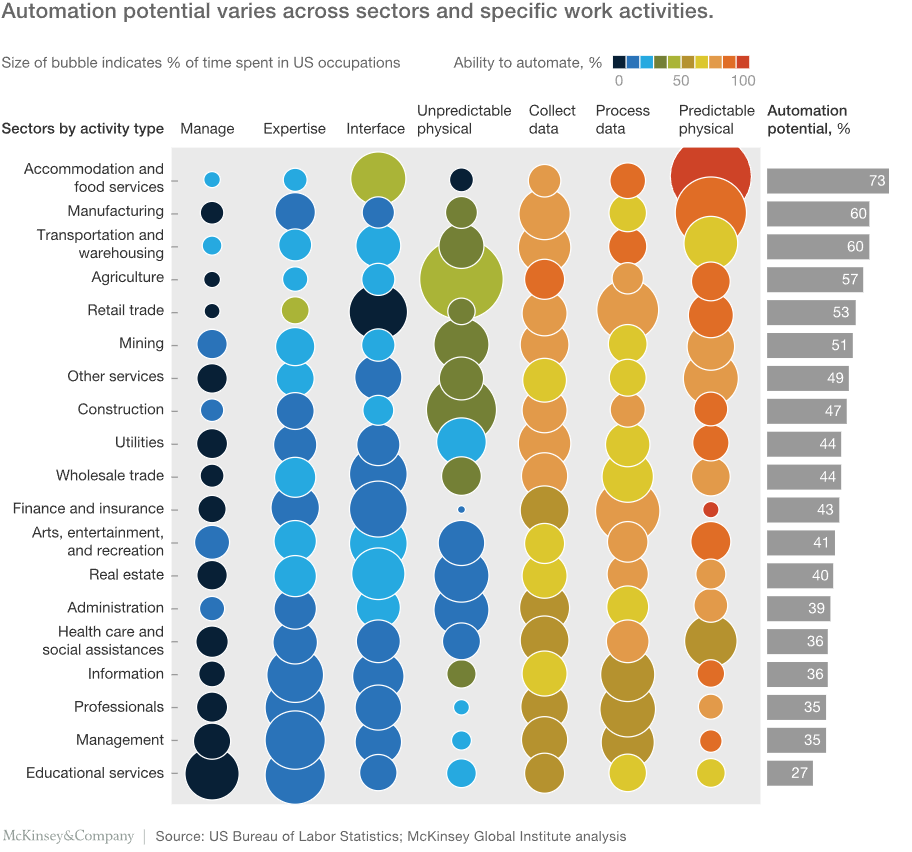

https://www.mckinsey.com/capabilities/operations/our-insights/human-plus-machine-a-new-era-of-automation-in-manufacturing#/

According to ther article, in manufacturing "87 percent of hours are spent on activities performed by workers in production occupations [which] are automatable." Since then manufacturing has begun to automate these production occupation hours, but what has changed since then is the rapid development of AI technologies. These developments could help not only the production departments buyt other departments as well. In engineering pecifically, Mckinsey estimates that 45 percent of working hours are automatable. Cutting down on any of this time would boost effiencies in any company exponentially.

## Business Problem

> Our stakeholder is looking to **reduce engineering time** to **assign the manufacturing process** for a custom fabricated **part**.

Our client has already worked to automate large portions of the shop/production floor by having robots and more sophisticated machinery and software work in tandem with shop employees. Since upgrading production equipment and processes, they have seen the bottleneck in their facility start to shift from the production departments to their engineering and design departments. With the increased efficiency in production, the shop floor is always ahead of engineering and design, which means that the shop is consistently waiting on digital files and shop documentation in order to continue working on projects. They would like to boost the automation in the engineering and design departments.

Our client's long term goal is to create a system which can automatically identify and program parts for various assemblies. This in turn will reduce the amount of engineering time required for each project, and will free the team up to focus on other responsibilities. For this project is the catalyst of this long term goal. It will start by classifying the first step in the manufacturing process for each of the parts.

## Objective

> To develop a **graph nueral network** that can properly **identify** the **required processes** for each **3D modeled part**.

## Defining Metrics

The metric that is most important in our analysis is precision. We need to be really precise in our predictions, as an imprecise prediction means a material gets sent to the wrong workcell. This, at the least, means lost time for sending the material back to the previous station, but, at the worst, it could mean lost time and lost material if someone cuts stock they should not be cutting.

Our second metric to use (should there be only slight precision differences between models) will be F1-score. This will help us to balance precision against recall as we analyze the models.

## The Dataset

The dataset contains around 1000 models which are all parametric variations on 10 different types of fixtures. These models were collected over the course of a month as they passed from the engineering department to the production department. Each fixture is made up of a variety of parts, with each part having a different shape and a different material assigned. The parts make up assemblies which are identified and shown in the table below.

| Assembly  | Type  |
|---|---|
| Cab1  | Base Cabinet  |
| Cab2  | Wall Cabinet  |
| Cab3  | Pantry Cabinet  |
| Shelf1  | Removable Shelf  |
| Shelf2  | Floating Shelf  |
| Counter1  | Order Counter  |
| Station1  | Utensil Station  |
| Bench1  | Bench with back  |
| Bench2  | Bench with no back  |
| Table1  | Table  |

All of the original solidworks models of these assemblies are located in the SW_Models folder. Each of these solidworks models have a design table which has multiple configurations of each assembly. For example, Station2 has 21 configurations of its model (not including the default configuration which was not used in this project). Each of these configurations have a different length, and width so as to create varied parts for the models to process. All of the different variations and the attributes of each are detailed in the file "Part_classification-Variations.csv" file.

After all of the models and configurations were setup, each of the solidworks models were converted to meshes by using a well built script by SigmaRelief off of github, which you can find at the link below:

https://github.com/SigmaRelief/SOLIDWORKS-Export-to-Mesh

All of these converted meshes were stored in the Meshes folder of this repo. The naming convention of the meshes used the following default naming strategy:

*Assembly-Configuration - PartName*

Example:
The first part of the first configuration of Bench1 is:

Bench1-01 - Bench1-01-1


## Modeling

The modeling uses a Pytorch covolutional nueral network approach, where all of the data being fed in is resampled to have the same size.

Our models include one base model, an augmented data model, and a fine tuned model. All of the models have a Logsoftmax function in order to generate probabilities for each of the classes of the multiclass classification problem. We will show that the fine tuned model seems to give us the best results due to the additional convolutional layers, dropout layers, and specialized AdamW optimizer. 

# Data Understanding

## Loading Packages

We will start by importing the libraries required for the notebook and pulling in the data:

In [84]:
#import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()
sns.set(rc={'savefig.dpi':300, 'figure.figsize':(12,8)})
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import trimesh
import numpy as np
from numpy.random import default_rng
import math
import random
from mpl_toolkits.mplot3d import Axes3D

# import meshplot as mp
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from torch.nn.functional import normalize
from pytorch3d.io import load_obj
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.structures import Meshes
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


## Plotting Sample Meshes

Lets take a look at some of the mesh files to get a better idea of the data we are working with.

In [124]:
# Set the base directory for where the original files are located
base_dir = 'Meshes/0_FabInc_NoClass'
files_dir = []
files_dir = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if os.path.isfile(os.path.join(base_dir, f))]
base_meshes = []

# Start a random generator and randomly load meshes from the directory
rng = default_rng(seed=49)
rand_nums = rng.choice(len(files_dir), size=9, replace=False)
for i in rand_nums:
    base_meshes.append((trimesh.load_mesh(files_dir[i]), str(files_dir[i])))

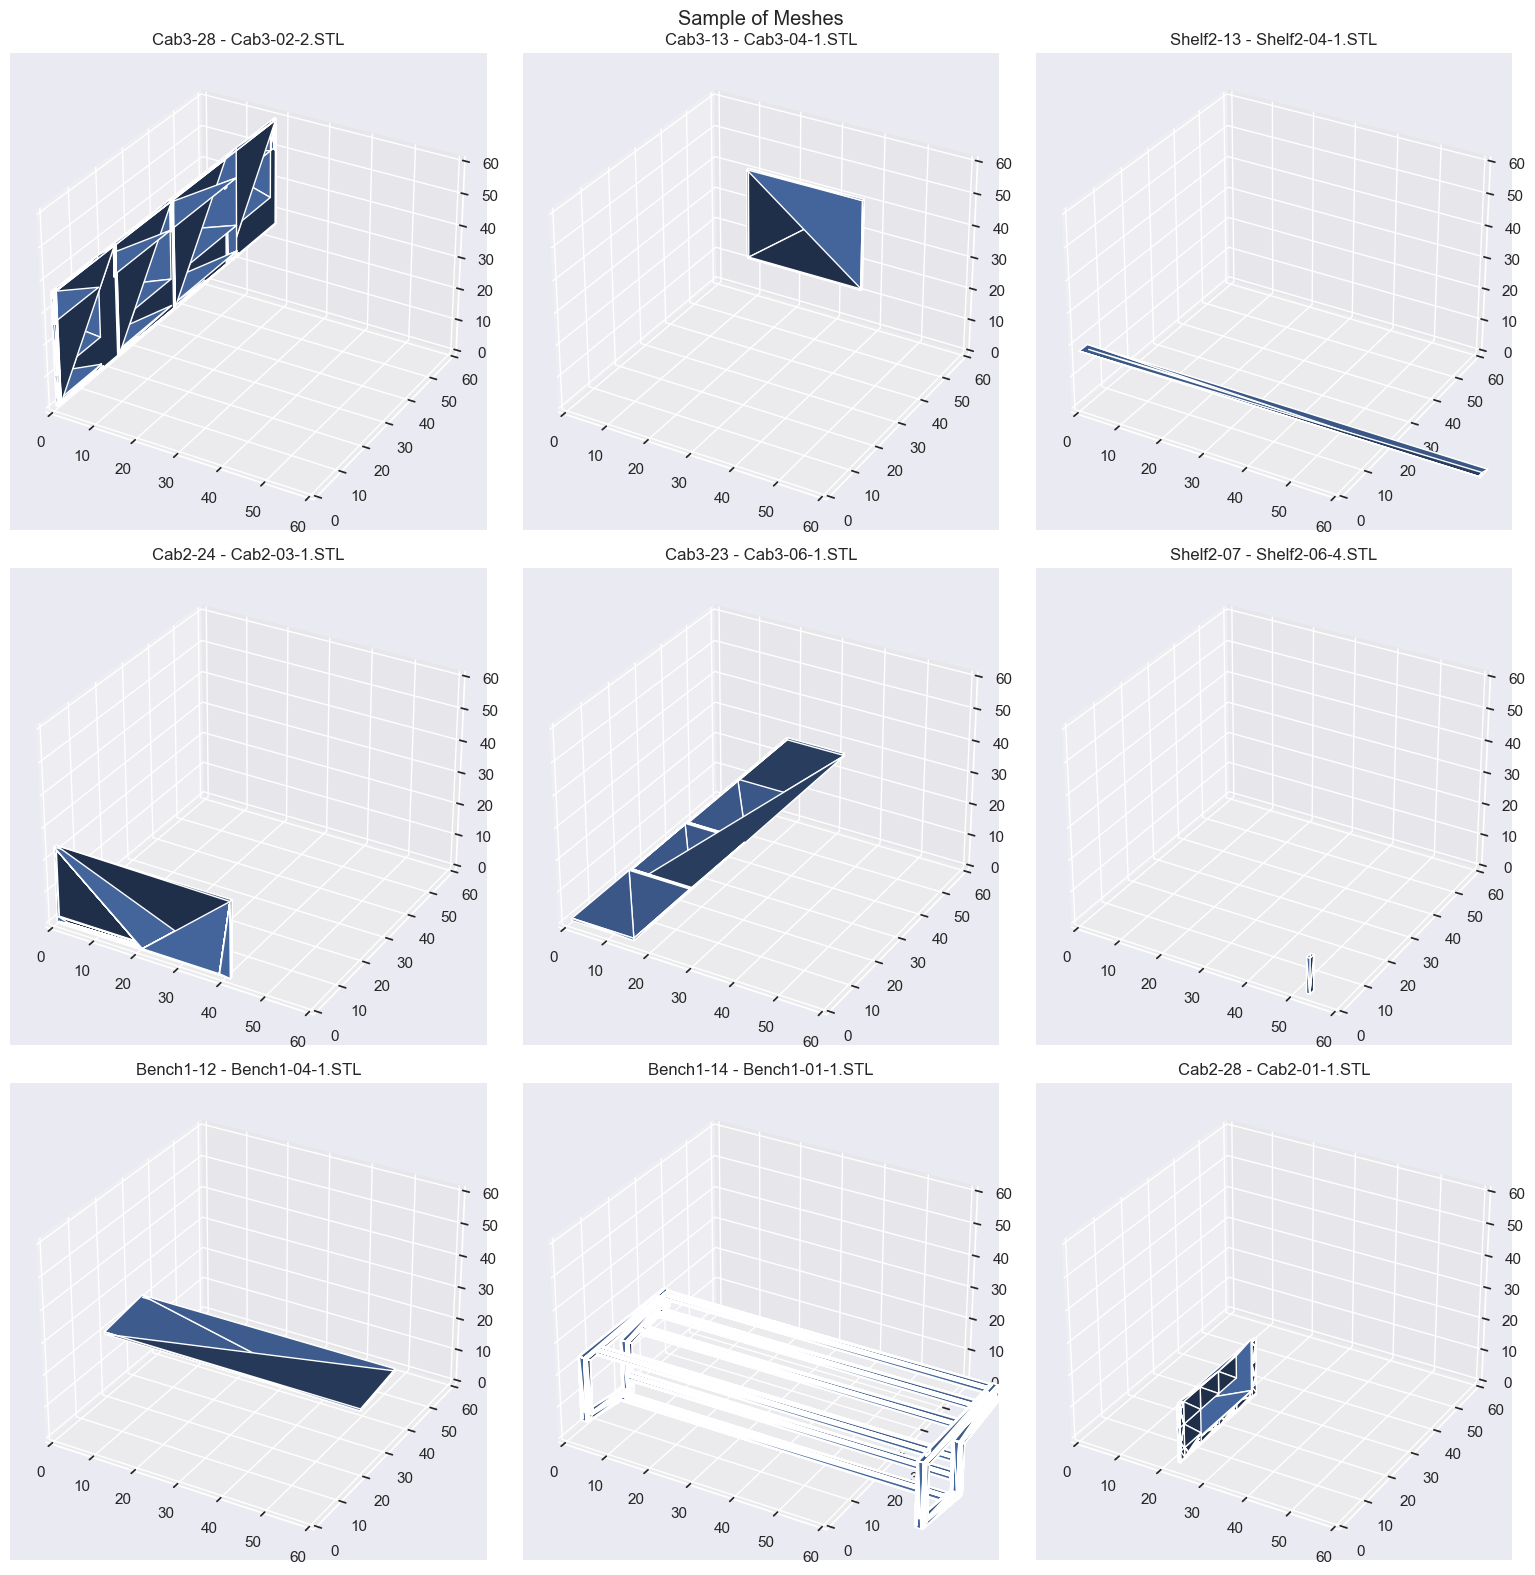

In [125]:
# Plot multiple plots from sample of meshes

i = 0
fig = plt.figure(figsize=(16,16))
fig.suptitle('Sample of Meshes')

for mesh, file_name in base_meshes:
    ax = plt.subplot(3,3,i+1, projection='3d')
    ax.plot_trisurf(mesh.vertices[:,0], mesh.vertices[:,1], triangles=mesh.faces, Z=mesh.vertices[:,2])
    ax.set_xlim3d(0, 60)
    ax.set_ylim3d(0, 60)
    ax.set_zlim3d(0, 60)
    plt.title(file_name.split('\\',1)[1])
    plt.tight_layout()
    i += 1

plt.savefig('Visualizations/Sample-of-Meshes.png', bbox_inches='tight', transparent=True);

## Plot Target classes

In [5]:
# load target csv file into pandas dataframe
df_target = pd.read_csv('Part_Classification.csv')
df_target

,Iteration,Part Name,Material,Manufacturing Process
0,1.0,Bench1-01,Hot Rolled Steel,Metal Band Saw
1,1.0,Bench1-02,White Oak,Panel Saw
2,1.0,Bench1-03,White Oak,Panel Saw
3,1.0,Bench1-04,White Oak,Panel Saw
4,2.0,Bench1-01,Hot Rolled Steel,Metal Band Saw
...,...,...,...,...
990,24.0,Table1-02,Hot Rolled Steel,Metal Band Saw
991,25.0,Table1-02,Hot Rolled Steel,Metal Band Saw
992,26.0,Table1-02,Hot Rolled Steel,Metal Band Saw
993,27.0,Table1-02,Hot Rolled Steel,Metal Band Saw


Lets take a look at the material types that we have and the manufacturing processes we have.

In [6]:
# Show number of data points of each class
print(df_target['Material'].value_counts())
print(df_target['Manufacturing Process'].value_counts())

TFL                 500
White Oak           235
MDF                  84
Hot Rolled Steel     83
Stainless Steel      75
Caesarstone          18
Name: Material, dtype: int64
CNC               494
Panel Saw         325
Metal Band Saw     80
Metal Laser        78
Waterjet           18
Name: Manufacturing Process, dtype: int64


In [7]:
# Calculate percentages for each class
Value_counts = df_target['Manufacturing Process'].value_counts(normalize=True)*100
Vcts = [round(item, 2) for item in list(Value_counts.to_dict().values())]
Vcts

[49.65, 32.66, 8.04, 7.84, 1.81]

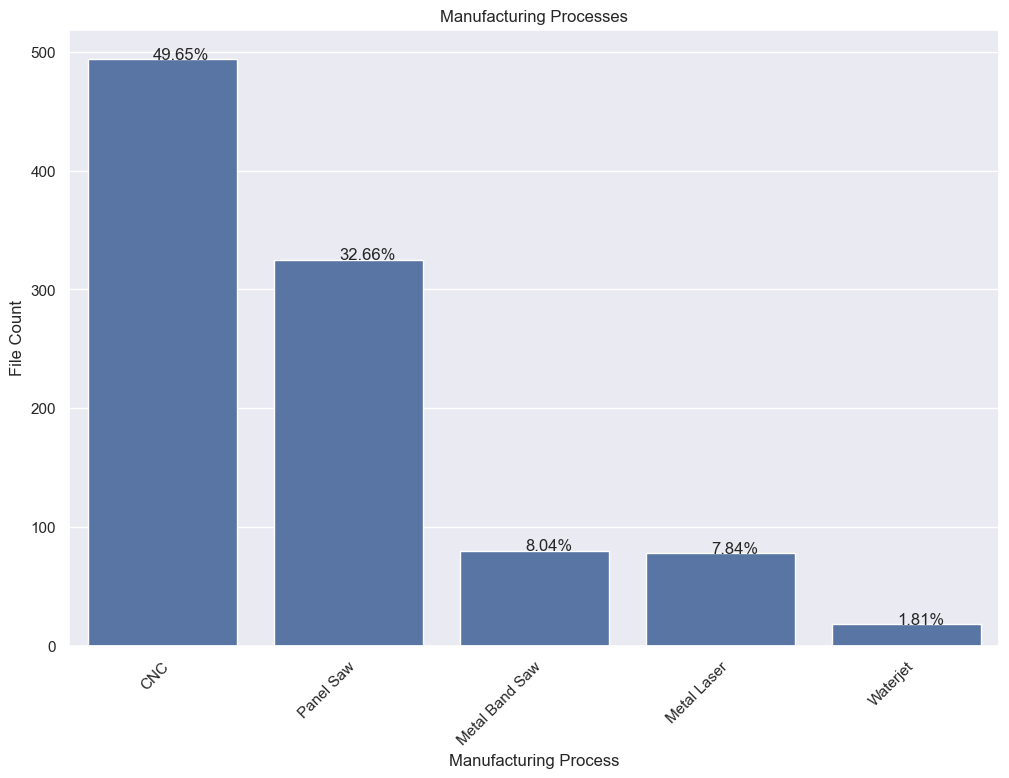

In [8]:
# Plot class types and percentages in barplot

Manu_type = df_target['Manufacturing Process'].value_counts(sort=True)
Value_counts = df_target['Manufacturing Process'].value_counts(normalize=True)*100
vctsdict = Value_counts.to_numpy()

ax = sns.barplot(x=Manu_type.index, y=Manu_type.values, color='b')
ax.set(xlabel='Manufacturing Process', ylabel='File Count', title='Manufacturing Processes')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

for val, p in enumerate(ax.patches):
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate((str(Vcts[val]) + '%'), (x, y), size = 12)

plt.savefig('Visualizations/Manufacturing-Processes-Bar-Chart.png', bbox_inches='tight', transparent=True)        
plt.show();

Looks like we have a severe class imbalance. So we will need to do accomodate for this in our data preparation to adjust for this imbalance.

## Time and Material Cost Analysis

In order to get a better idea of the cost of error from a misprediction, we will calculate the cost of time and material for these processes. Lets start first with calculating time required.

Each of these machining processes take a certain amount of time in order to setup the machine and cut the material. We do not have definitive statistics that detail the average amount of time for each process, but we do have estimates from the company for the estimated cut time per item (in minutes) and the machining cost per hour. We will use these estimates to formulate a total cost of machining time per month.

In [10]:
# Create a dictionary from data acquired from FabInc
Cost_Time = {'Manufacturing Process': ['CNC', 'Metal Band Saw', 'Metal Laser', 'Panel Saw', 'Waterjet'], 
    'Estimated Cut Time per Item (minutes)': [30, 30, 25, 15, 60],
    'Machining Cost per Hour ($)': [150, 90, 250, 110, 175]}

# Create pandas dataframe of information
Cost_Time_df = pd.DataFrame(Cost_Time).set_index('Manufacturing Process')

# Create additional columns to calculate "time cost per month"
Cost_Time_df['Estimated Cut Time per Item (hours)'] = Cost_Time_df['Estimated Cut Time per Item (minutes)']/60
Cost_Time_df['Average Machine Time Cost per item ($)'] = Cost_Time_df['Estimated Cut Time per Item (hours)'] * Cost_Time_df['Machining Cost per Hour ($)']
Cost_Time_df['Total Items'] = Manu_type
Cost_Time_df['Time Cost per month ($)'] = Cost_Time_df['Total Items'] * Cost_Time_df['Average Machine Time Cost per item ($)']
Cost_Time_df

,Estimated Cut Time per Item (minutes),Machining Cost per Hour ($),Estimated Cut Time per Item (hours),Average Machine Time Cost per item ($),Total Items,Time Cost per month ($)
Manufacturing Process,,,,,,
CNC,30,150,0.500000,75.000000,494,37050.0
Metal Band Saw,30,90,0.500000,45.000000,80,3600.0
Metal Laser,25,250,0.416667,104.166667,78,8125.0
Panel Saw,15,110,0.250000,27.500000,325,8937.5
Waterjet,60,175,1.000000,175.000000,18,3150.0


We will also want to take a look at the materials and their cost implications. 

For all of the materials, we can calculate the square footage price of each of the products, and then compare what a typical material cut mistake would cost. We can then correlate the materials to the manufacturing processes to see which one will be the most important in incurring cost due to error.

FabInc gave us initial cost per stock and average stock item yield per part to start with.

In [11]:
# Create a dictionary from data acquired from FabInc
Cost_Material = {'Material': ['Caesarstone', 'Hot Rolled Steel', 'MDF', 'Stainless Steel', 'TFL', 'White Oak'], 
     'Assumed Standard Size': ['305cm x 144cm x 2cm', '48" x 96" x 16 gauge', '49" x 97" x 3/4"', '48" x 96" x 16 gauge', '49" x 97" x 3/4"', '7" x 60" x 3/4"'],
    'Cost per stock item ($)': [1200, 420, 45, 670, 35, 10.90],
    'Stock item yield per part': [0.21, 0.13, 0.43, 0.18, 0.78, 3.24]}

# CReate pandas dataframe of information
Cost_Material_df = pd.DataFrame(Cost_Material).set_index('Material')

# Create additional columns to calculate "Cost per item"
Cost_Material_df['Cost per item ($)'] = Cost_Material_df['Cost per stock item ($)']*Cost_Material_df['Stock item yield per part']
Cost_Material_df

,Assumed Standard Size,Cost per stock item ($),Stock item yield per part,Cost per item ($)
Material,,,,
Caesarstone,305cm x 144cm x 2cm,1200.0,0.21,252.000
Hot Rolled Steel,"48"" x 96"" x 16 gauge",420.0,0.13,54.600
MDF,"49"" x 97"" x 3/4""",45.0,0.43,19.350
Stainless Steel,"48"" x 96"" x 16 gauge",670.0,0.18,120.600
TFL,"49"" x 97"" x 3/4""",35.0,0.78,27.300
White Oak,"7"" x 60"" x 3/4""",10.9,3.24,35.316


In [9]:
# Create a crosstab of material vs manufacturing process
crosstab = pd.crosstab(df_target['Manufacturing Process'], df_target['Material'], margins=True)
crosstab

Material,Caesarstone,Hot Rolled Steel,MDF,Stainless Steel,TFL,White Oak,All
Manufacturing Process,,,,,,,
CNC,0,0,70,0,424,0,494
Metal Band Saw,0,65,0,15,0,0,80
Metal Laser,0,18,0,60,0,0,78
Panel Saw,0,0,14,0,76,235,325
Waterjet,18,0,0,0,0,0,18
All,18,83,84,75,500,235,995


In [12]:
# Multiply crosstab by material cost per item
Cost_Material_Process = crosstab.multiply(Cost_Material_df['Cost per item ($)'].T, axis='columns')

# Sum all rows to recreate 'All' column
Cost_Material_Process['All'] = pd.DataFrame(Cost_Material_Process.sum(axis=1))

# Format 'All' column to be positioned at end of dataframe
temp_cols=Cost_Material_Process.columns.tolist()
new_cols=temp_cols[1:] + temp_cols[0:1]
Cost_Material_Process=Cost_Material_Process[new_cols]
Cost_Material_Process

Material,Caesarstone,Hot Rolled Steel,MDF,Stainless Steel,TFL,White Oak,All
Manufacturing Process,,,,,,,
CNC,0.0,0.0,1354.5,0.0,11575.2,0.00,12929.70
Metal Band Saw,0.0,3549.0,0.0,1809.0,0.0,0.00,5358.00
Metal Laser,0.0,982.8,0.0,7236.0,0.0,0.00,8218.80
Panel Saw,0.0,0.0,270.9,0.0,2074.8,8299.26,10644.96
Waterjet,4536.0,0.0,0.0,0.0,0.0,0.00,4536.00
All,4536.0,4531.8,1625.4,9045.0,13650.0,8299.26,41687.46


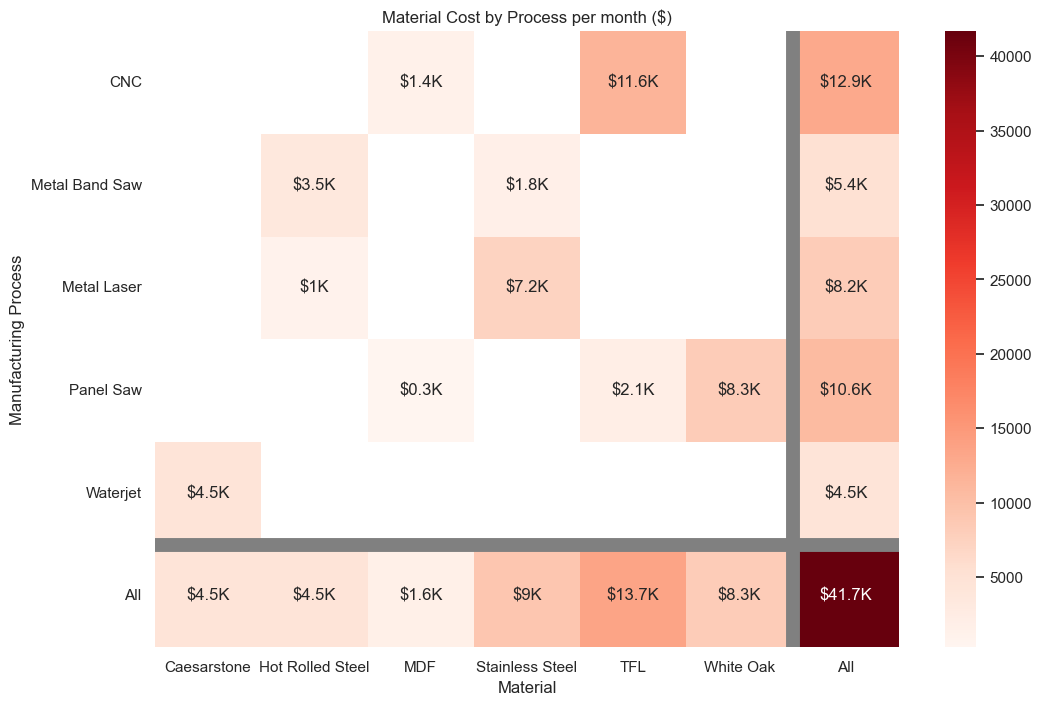

In [119]:
# Create heatmap of 'Material Cost per month'

df_cost_material_formatted = Cost_Material_Process.applymap(
    lambda val: f'${val / 1000:,.0f}K' if round(val / 100) % 10 == 0 else f'${val / 1000:,.1f}K')

ax = sns.heatmap(Cost_Material_Process,
           annot=df_cost_material_formatted,
           cmap='Reds',
           fmt='',
           mask=(Cost_Material_Process==0)
           )
ax.set_facecolor('white')
ax.axvline([6], *ax.get_ylim(), linewidth=10, color='gray')
ax.axhline([5], *ax.get_ylim(), linewidth=10, color='gray')
plt.yticks(rotation=0)
plt.title("Material Cost by Process per month ($)")
plt.savefig('Visualizations/Material-Cost.png', bbox_inches='tight', transparent=True);

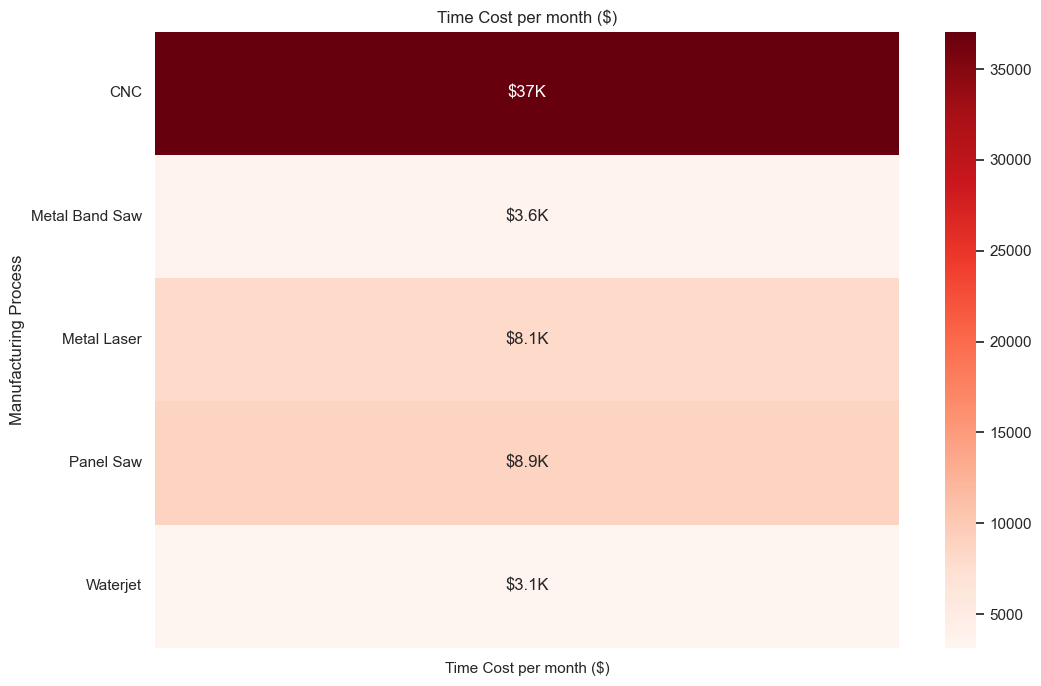

In [115]:
# Create heatmap of 'Time Cost per Month'

df_cost_time_formatted = Cost_Time_df['Time Cost per month ($)'].to_frame().applymap(
    lambda val: f'${val / 1000:,.0f}K' if round(val / 100) % 10 == 0 else f'${val / 1000:,.1f}K')
ax = sns.heatmap(Cost_Time_df['Time Cost per month ($)'].to_frame(),
           annot=df_cost_time_formatted,
           cmap='Reds',
           fmt=''
           )
plt.yticks(rotation=0)
plt.title("Time Cost per month ($)")
plt.savefig('Visualizations/Time-Cost.png', bbox_inches='tight', transparent=True);

In [15]:
# Create a totals dataframe, combining values from material and time costs
total_df = pd.DataFrame(data=[Cost_Time_df['Time Cost per month ($)'], Cost_Material_Process['All'].rename('Material Cost per month ($)')]).T
total_df['Total'] = total_df['Time Cost per month ($)'] * total_df['Material Cost per month ($)']
total_df.drop('All', axis=0, inplace=True)
total_df.loc['Total'] = total_df.sum(numeric_only=True)
total_df

,Time Cost per month ($),Material Cost per month ($),Total
Manufacturing Process,,,
CNC,37050.0,12929.70,479045385.0
Metal Band Saw,3600.0,5358.00,19288800.0
Metal Laser,8125.0,8218.80,66777750.0
Panel Saw,8937.5,10644.96,95139330.0
Waterjet,3150.0,4536.00,14288400.0
Total,60862.5,41687.46,674539665.0


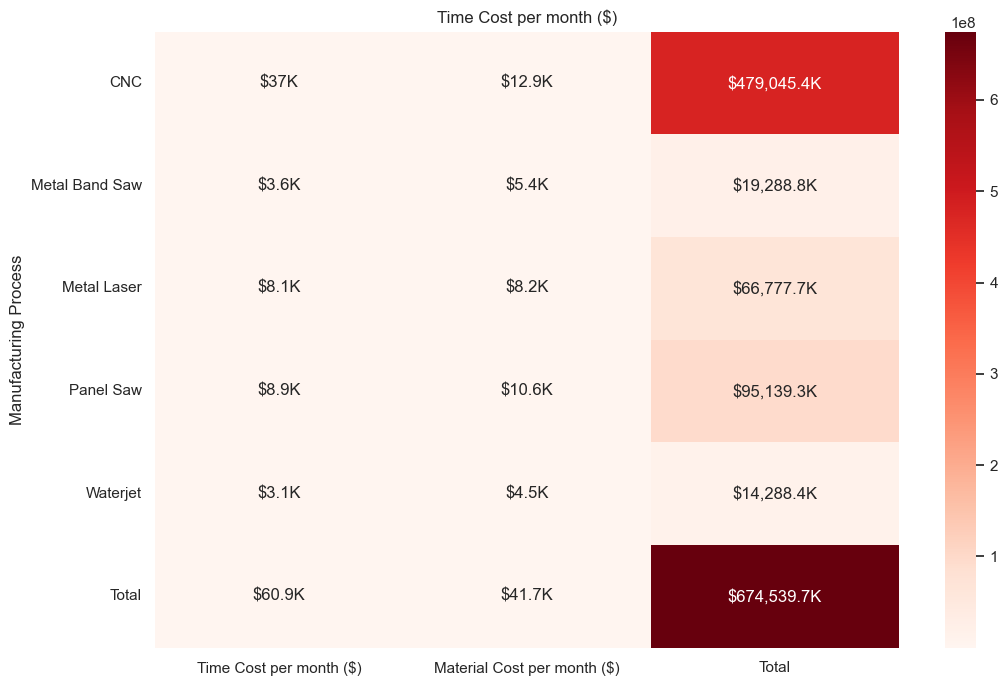

In [112]:
# Create heatmap of total_df
df_total_formatted = total_df.applymap(
    lambda val: f'${val / 1000:,.0f}K' if round(val / 100) % 10 == 0 else f'${val / 1000:,.1f}K')
ax = sns.heatmap(total_df,
           annot=df_total_formatted,
           cmap='Reds',
           fmt=''
           )
plt.yticks(rotation=0)
plt.title("Time Cost per month ($)")
plt.savefig('Visualizations/Time-Material-Cost.png', bbox_inches='tight', transparent=True);

## Explore Data Directory

https://towardsdatascience.com/how-to-create-a-list-of-files-folders-and-subfolders-and-then-export-as-excel-6ce9eaa3867a

In [17]:

import os
import pandas as pd
import sys
import tkinter.filedialog as tkfd

d_ext_desc = {'csv':'CSV file',
              'db':'Thumbnail',
              'doc':'Microsoft Word Document',
              'docx':'Microsoft Word Document',
              'GIF':'GIF Image file',
              'html':'HTML file',
              'ico':'Icon Image file',
              'jpg':'JPG Image file',
              'JPEG':'JPEG Image file',
              'json':'JSON file',
              'lnk':'Shortcut file',
              'msg':'Microsoft Outlook Message file',
              'pdf':'PDF file',
              'pkl':'Pickle (python) file',
              'png':'PNG Image file',
              'ppt':'Microsoft Powerpoint file',
              'pptx':'Microsoft Powerpoint file',
              'pst':'Microsoft Outlook Data file',
              'py':'Python file',
              'pyc':'Python file (compiled)',
              'rtf':'Rich Text Format',
              'svg':'SVG Image file',
              'stl':'Stereolithography Mesh',
              'txt':'Text document',
              'url':'Hyperlink',
              'vsd':'Microsoft Visio file',
              'xls':'Microsoft Excel file',
              'xlsb':'Microsoft Excel file',
              'xlsm':'Microsoft Excel (Macro-enabled) file',
              'xlsx':'Microsoft Excel file',
              'yml':'Requirements file (python)',
              'zip':'ZIP file'}

def ext_desc(ext):
    try:
        desc = d_ext_desc[ext]
    except KeyError:
        desc = ''
    else:
        pass
    return desc

def generate_index(path=None, max=500):
    # stops generating index whenever there are more than 500 records, to test if the script works
    # use 'max=0' to generate the full index
    
    path = path if path else tkfd.askdirectory() # Request path if not provided

    df = pd.DataFrame(columns=['File','File Type','Folder Location','Link','Path'])
    for root, _ , files in os.walk(path):
        files = [f for f in files if not f.startswith('~') and f!='Thumbs.db']
        paths = [os.path.join(root, f) for f in files]
        exts = [os.path.splitext(f)[1][1:].lower() for f in files]
        filetypes = [ext_desc(ext) for ext in exts]
        file_links = ['=HYPERLINK("{}","link")'.format(p) if len(p) < 256 else '' for p in paths]
        folders = [os.path.dirname(p) for p in paths]
        df1 = pd.DataFrame({'File': files,
                            'File Type': filetypes,
                            'Folder Location': folders,
                            'Link': file_links,
                            'Path': paths})
        df = df.append(df1)
        if max and (df.shape[0]>max):
            break
    df = df.reset_index(drop=True)
    return df
  
# if __name__ == '__main__':
#     df = generate_index(path='Meshes/', max=0)
#     df.to_excel('file_index.xlsx')

In [18]:
df_Mesh = generate_index(path='Meshes/0_FabInc_NoClass', max=0)
df_Mesh

C:\Users\Tim\AppData\Local\Temp\ipykernel_18300\1339250314.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df1)


,File,File Type,Folder Location,Link,Path
0,Bench1-01 - Bench1-01-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Bench1-01 ...",Meshes/0_FabInc_NoClass\Bench1-01 - Bench1-01-...
1,Bench1-01 - Bench1-02-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Bench1-01 ...",Meshes/0_FabInc_NoClass\Bench1-01 - Bench1-02-...
2,Bench1-01 - Bench1-03-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Bench1-01 ...",Meshes/0_FabInc_NoClass\Bench1-01 - Bench1-03-...
3,Bench1-01 - Bench1-04-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Bench1-01 ...",Meshes/0_FabInc_NoClass\Bench1-01 - Bench1-04-...
4,Bench1-02 - Bench1-01-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Bench1-02 ...",Meshes/0_FabInc_NoClass\Bench1-02 - Bench1-01-...
...,...,...,...,...,...
1120,Table1-26 - Table1-02-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Table1-26 ...",Meshes/0_FabInc_NoClass\Table1-26 - Table1-02-...
1121,Table1-27 - Table1-01-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Table1-27 ...",Meshes/0_FabInc_NoClass\Table1-27 - Table1-01-...
1122,Table1-27 - Table1-02-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Table1-27 ...",Meshes/0_FabInc_NoClass\Table1-27 - Table1-02-...
1123,Table1-28 - Table1-01-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Table1-28 ...",Meshes/0_FabInc_NoClass\Table1-28 - Table1-01-...


It looks like we have alot more files than what we have labels for. We have 1125 files and only 995 labels. I think this is probably due to the export function that was used in solidworks. In assemblies such as Cab3, there may be 6 unique parts, but one of the parts is repeated three times in the model (as there are three shelves in that cabinet). We will need to identify which files are duplicates and elminate them from the list in our Data prep phase.

We could probably confirm this by identifying a model which would have this happen. We could use Cab3 as our example to compare the differences between the files and the labels.

In [19]:
df_Mesh_cab3 = df_Mesh[df_Mesh['File'].str.contains('Cab3')]
df_Mesh_cab3[-5:]

,File,File Type,Folder Location,Link,Path
703,Cab3-28 - Cab3-04-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Cab3-28 - ...",Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-04-1.STL
704,Cab3-28 - Cab3-06-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Cab3-28 - ...",Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-06-1.STL
705,Cab3-28 - Cab3-07-1.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Cab3-28 - ...",Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-07-1.STL
706,Cab3-28 - Cab3-07-2.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Cab3-28 - ...",Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-07-2.STL
707,Cab3-28 - Cab3-07-3.STL,Stereolithography Mesh,Meshes/0_FabInc_NoClass,"=HYPERLINK(""Meshes/0_FabInc_NoClass\Cab3-28 - ...",Meshes/0_FabInc_NoClass\Cab3-28 - Cab3-07-3.STL


We can even see at the end of the cab3 mesh dataframe that there are three parts of the Cab3-07 part. We only really need one of each part, so as to not have any duplicates in the dataset. Luckily it seems the last number in the file name of the "File" column of the df_mesh dataframe identifies the duplicate instance of the part, so we can use that to create a dataframe that only has a singlke instance of each part.

But this does not match the 995 records we have in the other file either. In looking closer at one of the solidworks files, it looks like some of the parts that have the second number are mirrored parts in the assembly themselves

# Data Preparation

So for the data preparation we will need to do the following:

1. Create a dataframe that does not contain duplicate parts to use in modeling.
2. We will need to assign class weights to counteract the class imbalance in the dataset.
3. The data has to be prepared to be fed into a pytorch model by being batched into native datasets.

## Compare Target Dataframe to File Directory Dataframe

We will first compare the file names from the df_mesh frame to our names in the df_target dataframe we have, and see what names are in the csv file that are not in the mesh files.

In [20]:
# Remove file extension from string
df_MeshSplit1 = df_Mesh['File'].str.split('.', expand=True)[0]

# Remove first assembly name
df_MeshSplit2 = df_MeshSplit1.str.split('-', n=1, expand=True)[1]

# For any string that has more than 2 '-' characters (solidworks assembly files), return the index and the string that removes the last two characters
df_MeshSplit3 = [(i, string[:-2]) for i, string in enumerate(df_MeshSplit2) if string.count('-') > 2]

# Create dataframe and drop duplicates
df_MeshSplit4 = pd.DataFrame(df_MeshSplit3).set_index(0).drop_duplicates()

# For any string that has 1 '-' character (solidworks part files), return the index and the string
df_MeshSplit5 = [(i, string) for i, string in enumerate(df_MeshSplit1) if string.count('-') == 1]

# Create a dataframe and drop duplicates
df_MeshSplit6 = pd.DataFrame(df_MeshSplit5).set_index(0).drop_duplicates()

# Combine dataframes
df_Mesh2 = pd.concat([df_MeshSplit4, df_MeshSplit6], axis=0).sort_index()
df_Mesh2

,1
0,
0,01 - Bench1-01
1,01 - Bench1-02
2,01 - Bench1-03
3,01 - Bench1-04
4,02 - Bench1-01
...,...
1120,26 - Table1-02
1121,27 - Table1-01
1122,27 - Table1-02


So in total it looks like we have 914 unique files from the original mesh file dataframe. Lets use this set of files to reduce the target csv dataframe to have the exact same amount of files with the corresponding names.

In [21]:
# Reformat the existing file names from the csv file to match the actual mesh file names

# Convert original dataframe into Integer type
df_target['Iteration'] = df_target['Iteration'].astype('Int64')

# Combine the iteration and target column into one string
df_target['Compare'] = df_target['Iteration'].astype(str).str.zfill(2) + ' - ' + df_target['Part Name']
df_target['Compare']

0      01 - Bench1-01
1      01 - Bench1-02
2      01 - Bench1-03
3      01 - Bench1-04
4      02 - Bench1-01
            ...      
990    24 - Table1-02
991    25 - Table1-02
992    26 - Table1-02
993    27 - Table1-02
994    28 - Table1-02
Name: Compare, Length: 995, dtype: object

In [22]:
# Convert the df_target compare column to numpy set and compute difference between this set and the mesh file set
df_targetCompNumpy = df_target['Compare'].to_numpy()
set_diff = np.setxor1d(df_Mesh2, df_targetCompNumpy)
# Remove all of the Shelf1 files from the set_diff
new_set_diff = [x for x in set_diff if 'Shelf1' not in x]
new_set_diff

['01 - Bench2-04',
 '01 - Cab2-05',
 '01 - Cab3-05',
 '02 - Bench2-04',
 '02 - Cab2-05',
 '02 - Cab3-05',
 '03 - Bench2-04',
 '03 - Cab2-05',
 '03 - Cab3-05',
 '04 - Bench2-04',
 '04 - Cab2-05',
 '04 - Cab3-05',
 '05 - Bench2-04',
 '05 - Cab2-05',
 '05 - Cab3-05',
 '06 - Bench2-04',
 '06 - Cab2-05',
 '06 - Cab3-05',
 '07 - Bench2-04',
 '07 - Cab2-05',
 '07 - Cab3-05',
 '08 - Bench2-04',
 '08 - Cab2-05',
 '08 - Cab3-05',
 '09 - Bench2-04',
 '09 - Cab2-05',
 '09 - Cab3-05',
 '10 - Bench2-04',
 '10 - Cab2-05',
 '10 - Cab3-05',
 '11 - Bench2-04',
 '11 - Cab2-05',
 '11 - Cab3-05',
 '12 - Bench2-04',
 '12 - Cab2-05',
 '12 - Cab3-05',
 '13 - Bench2-04',
 '13 - Cab2-05',
 '13 - Cab3-05',
 '14 - Bench2-04',
 '14 - Cab2-05',
 '14 - Cab3-05',
 '15 - Bench2-04',
 '15 - Cab2-05',
 '15 - Cab3-05',
 '16 - Bench2-04',
 '16 - Cab2-05',
 '16 - Cab3-05',
 '17 - Bench2-04',
 '17 - Cab2-05',
 '17 - Cab3-05',
 '18 - Bench2-04',
 '18 - Cab2-05',
 '18 - Cab3-05',
 '19 - Bench2-04',
 '19 - Cab2-05',
 '19 - Cab

It looks like the there might have been some parts in the solidworks assemblies that no longer exist as we have some parts that are not a part of any of the mesh file names. We will need to remove all Cab2-05, Cab3-05, and Bench2-04 parts from the csv file.

In [23]:
df_target2 = df_target[df_target['Part Name'].str.contains('Cab2-05|Cab3-05|Bench2-04') == False]
df_target2

,Iteration,Part Name,Material,Manufacturing Process,Compare
0,1,Bench1-01,Hot Rolled Steel,Metal Band Saw,01 - Bench1-01
1,1,Bench1-02,White Oak,Panel Saw,01 - Bench1-02
2,1,Bench1-03,White Oak,Panel Saw,01 - Bench1-03
3,1,Bench1-04,White Oak,Panel Saw,01 - Bench1-04
4,2,Bench1-01,Hot Rolled Steel,Metal Band Saw,02 - Bench1-01
...,...,...,...,...,...
990,24,Table1-02,Hot Rolled Steel,Metal Band Saw,24 - Table1-02
991,25,Table1-02,Hot Rolled Steel,Metal Band Saw,25 - Table1-02
992,26,Table1-02,Hot Rolled Steel,Metal Band Saw,26 - Table1-02
993,27,Table1-02,Hot Rolled Steel,Metal Band Saw,27 - Table1-02


In [24]:
# Double check that all rows are unique
df_target2['Compare'].value_counts()

01 - Bench1-01      1
07 - Counter1-04    1
08 - Counter1-01    1
08 - Counter1-02    1
08 - Counter1-03    1
                   ..
20 - Cab2-01        1
20 - Cab2-02        1
20 - Cab2-03        1
20 - Cab2-04        1
28 - Table1-02      1
Name: Compare, Length: 914, dtype: int64

Great, now we have our new target dataframe where the row count matches the mesh files.

We will need to make a separate csv file that only contains the unique rows, which we identified in our prepared Mesh dataframe. We can use this csv file to extract the exact mesh file names and organize the files in a folder structure that defines the class of the file as well as what set the file is located in, whether in validation set, train set, or test set.

In [25]:
df_Mesh3 = df_Mesh.iloc[df_Mesh2.index]
df_target3 = df_target2.reset_index()
df_Mesh3.reset_index(inplace=True)
df_Mesh3 = df_Mesh3.join(df_target3['Manufacturing Process'])
df_Mesh4 = df_Mesh3.drop(labels=['File Type', 'Folder Location', 'Link', 'Path', 'index'], axis=1)
df_Mesh4['File'] = df_Mesh4['File'].str.split('.', expand=True)[0]
df_Mesh4

,File,Manufacturing Process
0,Bench1-01 - Bench1-01-1,Metal Band Saw
1,Bench1-01 - Bench1-02-1,Panel Saw
2,Bench1-01 - Bench1-03-1,Panel Saw
3,Bench1-01 - Bench1-04-1,Panel Saw
4,Bench1-02 - Bench1-01-1,Metal Band Saw
...,...,...
909,Table1-26 - Table1-02-1,Metal Band Saw
910,Table1-27 - Table1-01-1,Metal Band Saw
911,Table1-27 - Table1-02-1,Metal Band Saw
912,Table1-28 - Table1-01-1,Metal Band Saw


In [26]:
# Write dataframe out to csv file
df_Mesh4.to_csv('Meshes/Data_Mesh_Target.csv', index=False)

## Use Train-Split-Multiclass Notebook

In order to prepare the files to feed into the models, we have to organize the data in a couple of ways:

- On Pytorch3d and meshcnn's websites, the documentation says they can only support ply, or obj formats. Unfortunately all of our meshes are in stl, so they will need to be converted to another format. We will convert them to obj format.
- We need to organize the files into folders for each class.
- The class folders also have to be organized into separate train, validation, and test folders themselves.

At this point, we used the Train-Split-Multiclass notebook stored in Mesh_Preprocessing_Notebooks to accomplish the tasks in the list above.

## Assign Class Weights

Lets assign weights to all of the classes now for use when modeling

In [27]:
# total number of items
total = len(df_target2)

In [28]:
# Determine the value counts of each class
Class_total = list(df_target2['Manufacturing Process'].value_counts())

In [29]:

# Scaling by total/5 to keep the loss to a similar magnitude 
# multiplied by a fraction of the total for each class to determine the class weight.
weight_for_0 = (1 / Class_total[0]) * (total / 5.0)
weight_for_1 = (1 / Class_total[1]) * (total / 5.0)
weight_for_2 = (1 / Class_total[2]) * (total / 5.0)
weight_for_3 = (1 / Class_total[3]) * (total / 5.0)
weight_for_4 = (1 / Class_total[4]) * (total / 5.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}

print('Weight for class CNC: {:.2f}'.format(weight_for_0))
print('Weight for class Panel Saw: {:.2f}'.format(weight_for_1))
print('Weight for class Metal Band Saw: {:.2f}'.format(weight_for_2))
print('Weight for class Metal Laser: {:.2f}'.format(weight_for_3))
print('Weight for class Waterjet: {:.2f}'.format(weight_for_4))

Weight for class CNC: 0.42
Weight for class Panel Saw: 0.60
Weight for class Metal Band Saw: 2.29
Weight for class Metal Laser: 2.34
Weight for class Waterjet: 10.16


## Plot Distribution of Mesh Vertices

In [30]:
raw_file_dir = 'Meshes/1A_FabInc_OBJ_Class'
folders = [dir for dir in sorted(os.listdir(raw_file_dir)) if os.path.isdir(raw_file_dir + '/' + dir)]
mesh_sizes_tup = []
classes = {folder: i for i, folder in enumerate(folders)}

for category in classes.keys():
    new_dir = raw_file_dir/Path(category)
    for file in os.listdir(new_dir):
        f = os.path.join(new_dir, file)
        mesh = load_obj(f)
        mesh_sizes_tup.append((mesh[0].size(), file))

C:\Users\Tim\anaconda3\envs\pytorch3d\lib\site-packages\pytorch3d\io\obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [31]:
mesh_min = min(mesh_sizes_tup)
mesh_max = max(mesh_sizes_tup)
print('The largest tensor is', list(mesh_max[0]), 'from the file', mesh_max[1])
print('The smallest tensor is', list(mesh_min[0]), 'from the file', mesh_min[1])

The largest tensor is [5989, 3] from the file Counter1-06 - Counter1-01-1.obj
The smallest tensor is [8, 3] from the file Bench1-01 - Bench1-02-1.obj


In [32]:
mesh_sizes = []
[mesh_sizes.append(list(mesh_size[0])[0]) for mesh_size in mesh_sizes_tup]
mesh_sizes[0:10]

[812, 812, 228, 12, 812, 812, 228, 12, 812, 812]

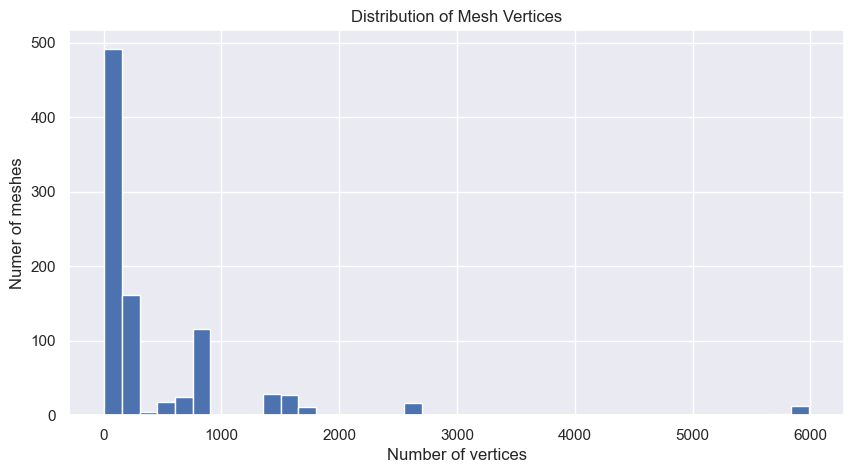

In [33]:
# plot the distribution of mesh vertices
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(mesh_sizes, bins=40)

ax.ticklabel_format(useOffset=False, style='plain')
ax.set_xlabel("Number of vertices")
ax.set_ylabel("Numer of meshes")
ax.set_title("Distribution of Mesh Vertices");


# plt.xlim([0, 2])

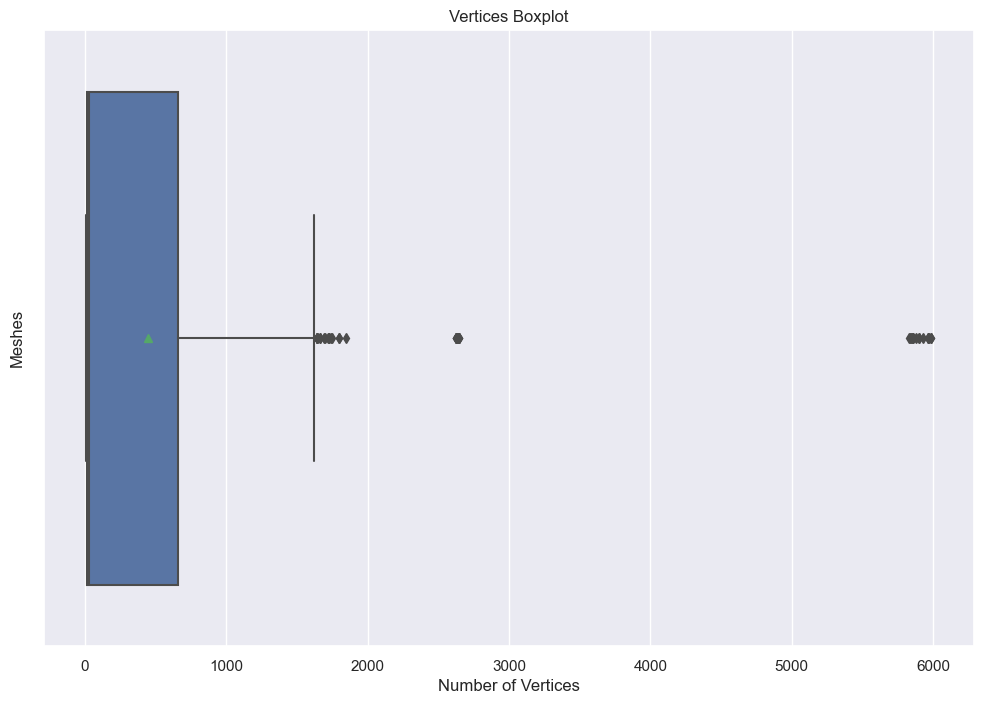

In [34]:
# check charges variable for outliers
sns.boxplot(x=mesh_sizes, 
            showmeans=True
).set(
    xlabel='Number of Vertices',
    ylabel='Meshes',
    title='Vertices Boxplot');



Looks like there are a portion of outliers at the 6000 vertices mark. We certainly dont need all of the vertices to be sampled that high for some outliers. But we wouldnt want to sample it too low that it would destroy the detail in the model. Lets see what the average, median and quartiles come to be.

In [35]:
#  IQR
Q1 = np.percentile(mesh_sizes, 25)
 
Q3 = np.percentile(mesh_sizes, 75)
IQR = Q3 - Q1
 
# Upper bound
upper = Q3+1.5*IQR
# Lower bound
lower = Q1-1.5*IQR 

print('Average:', np.average(mesh_sizes))
print('Median:', np.median(mesh_sizes))
print('1st Quantile:', Q1)
print('3rd Quantile:', Q3)
print('Lower Bound:', lower)
print('Upper Bound:', upper)


Average: 443.6269146608315
Median: 32.0
1st Quantile: 12.0
3rd Quantile: 656.0
Lower Bound: -954.0
Upper Bound: 1622.0


I would think the upper bound might be the best middle ground between the meshes with the high 6000 vertices (without reducing too much detail) and the meshes with the lowest vertices.

In [36]:
num_samples=int(upper)

## Mesh Dataset and Dataloader

In [37]:
# https://github.com/nikitakaraevv/pointnet

class MeshData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=None, num_samples=None):
        '''
        The folder structure to use this class needs to be organized as follows:
        train
            category
                file1
                file2
                ...
            category2
                file1
                file2
                ...
            category3
                file1
                file2
                ...
        test
            category
                file1
                file2
                ...
            category2
                file1
                file2
                ...
            category3
                file1
                file2
                ...


        The root_dir needs to be specified as the train, or test folders
        '''
    
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir + '/' + dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform
        self.num_samples = num_samples
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)
            for file in os.listdir(new_dir):
                if file.endswith('.obj'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)
        


    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        mesh = load_obj(file)
        verts = mesh[0]
        if self.num_samples:
            mesh = Meshes([mesh[0]], [mesh[1][0]])
            mesh_sam = sample_points_from_meshes(mesh, num_samples=num_samples)
            mesh_sam_sq = torch.squeeze(mesh_sam)
            verts_p = mesh_sam_sq
        else:
            verts_p = verts
        if self.transforms:
            verts_p = self.transforms(verts_p)
        return verts_p

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            mesh = self.__preproc__(f)
        return {'mesh': mesh, 
                'category': self.classes[category]}

In [38]:
train_path = 'Meshes/1B_FabInc/train'
val_path = 'Meshes/1B_FabInc/val'

In [39]:
train_ds = MeshData(train_path, num_samples=num_samples)

In [40]:
valid_ds = MeshData(val_path, num_samples=num_samples)

In [41]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'CNC',
 1: 'Metal Band Saw',
 2: 'Metal Laser',
 3: 'Panel Saw',
 4: 'Waterjet'}

In [42]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample mesh vertices shape: ', train_ds[0]['mesh'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  730
Valid dataset size:  88
Number of classes:  5
Sample mesh vertices shape:  torch.Size([1622, 3])
Class:  CNC


C:\Users\Tim\anaconda3\envs\pytorch3d\lib\site-packages\pytorch3d\io\obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [43]:
train_items = train_ds.__len__()
train_items

730

In [44]:
# Set batch size
batch_size = 32

In [45]:
num_batches = math.ceil(train_items/batch_size)
num_batches

23

In [46]:
train_loader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=batch_size*2)

# Modeling

## Base Model

https://github.com/nikitakaraevv/pointnet

We will start with a base model. Given the nature of the mesh data structure, we use the unedited version of the PointNet nueral network from nikitakaraevv to classify the meshes to start.

In [47]:
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 5):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [48]:
# Calculate the model loss
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [49]:
# set the device. If cuda is available, use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pointnet = PointNet()
pointnet.to(device);

# Load a pre-trained model if it exists
# pointnet.load_state_dict(torch.load('../input/pointnet-for-3d-object-classification-pytorch/save.pth'))

# set optimizer to the adam optimizer
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.00025)

In [50]:
# Set number of epochs
epochs = 20

In [51]:
# define the train model
def train(model, train_loader, val_loader,  epochs, accuracy_loss):
    train_items = train_loader.dataset.__len__()
    batch_size = train_loader.batch_size
    num_batches = math.ceil(train_items/batch_size)
    for epoch in range(epochs): 
        pointnet.train()
        batch_loss = 0.0
        running_loss = 0.0
        train_correct = train_total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['mesh'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            batch_loss += loss.item()
            if i % 5 == 4:    # print every 10 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                    (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0


            # Calculate training accuracy
            outputs, __, __ = pointnet(inputs.transpose(1,2))
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()              
        acc = 100. * train_correct / train_total    
        
        pointnet.eval()
        val_correct = val_total = 0

        # validation
        if val_loader:
            val_loss = 0.0
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['mesh'].to(device).float(), data['category'].to(device)
                    outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))
                    loss = pointnetloss(outputs, labels, m3x3, m64x64)

                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    val_loss += loss.item()
            val_acc = 100. * val_correct / val_total
            print('Valid Accuracy: %d %%' % val_acc, '- Accuracy: %d %%' % acc, '- Valid Loss: %.3f' % val_loss )

        # save the model
        torch.save(pointnet.state_dict(), "save.pth")

        # save accuracy and loss to list
        accuracy_loss.append({
           'Epoch': epoch,
           'Loss': batch_loss/num_batches,
           'Accuracy': acc,
           'Val_Accuracy': val_acc,
           'Val_Loss': val_loss
        })

In [52]:
# run the training model
accuracy_loss = []
train(pointnet, train_loader, valid_loader, epochs, accuracy_loss)

[Epoch: 1, Batch:    5 /   23], loss: 0.764
[Epoch: 1, Batch:   10 /   23], loss: 0.674
[Epoch: 1, Batch:   15 /   23], loss: 0.599
[Epoch: 1, Batch:   20 /   23], loss: 0.571
Valid Accuracy: 54 % - Accuracy: 61 % - Valid Loss: 2.431
[Epoch: 2, Batch:    5 /   23], loss: 0.490
[Epoch: 2, Batch:   10 /   23], loss: 0.476
[Epoch: 2, Batch:   15 /   23], loss: 0.451
[Epoch: 2, Batch:   20 /   23], loss: 0.451
Valid Accuracy: 72 % - Accuracy: 72 % - Valid Loss: 1.637
[Epoch: 3, Batch:    5 /   23], loss: 0.372
[Epoch: 3, Batch:   10 /   23], loss: 0.366
[Epoch: 3, Batch:   15 /   23], loss: 0.303
[Epoch: 3, Batch:   20 /   23], loss: 0.337
Valid Accuracy: 77 % - Accuracy: 78 % - Valid Loss: 1.336
[Epoch: 4, Batch:    5 /   23], loss: 0.285
[Epoch: 4, Batch:   10 /   23], loss: 0.310
[Epoch: 4, Batch:   15 /   23], loss: 0.290
[Epoch: 4, Batch:   20 /   23], loss: 0.270
Valid Accuracy: 85 % - Accuracy: 83 % - Valid Loss: 1.079
[Epoch: 5, Batch:    5 /   23], loss: 0.281
[Epoch: 5, Batch:   

In [53]:
accuracy_loss_df = pd.DataFrame.from_records(accuracy_loss)
accuracy_loss_df = accuracy_loss_df.set_index('Epoch')
accuracy_loss_df

,Loss,Accuracy,Val_Accuracy,Val_Loss
Epoch,,,,
0,1.269461,61.506849,54.545455,2.430740
1,0.906430,72.191781,72.727273,1.636622
2,0.683231,78.904110,77.272727,1.335894
3,0.586723,83.561644,85.227273,1.078509
4,0.538937,85.205479,82.954545,1.139922
5,0.473340,86.301370,86.363636,1.019497
6,0.468858,86.027397,89.772727,0.738081
7,0.421201,87.945205,85.227273,0.759440
8,0.413007,89.178082,85.227273,0.777054


In [54]:
# evaluate the model to get predictions and true labels
pointnet.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
        
        inputs, labels = data['mesh'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

C:\Users\Tim\anaconda3\envs\pytorch3d\lib\site-packages\pytorch3d\io\obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


Batch [   1 /    2]
Batch [   2 /    2]


In [55]:
# calculate all classes
classes = list(train_ds.classes.keys())

In [56]:
# Define a function to show classification report and confusion matrix
def show_classification_report_and_confusion_matrix(model, 
                                                    y_pred,
                                                    y_test,
                                                    classes, 
                                                    cm_cmap, 
                                                    cr_cmap, 
                                                    cm_title, 
                                                    cr_title):
    

    
    # Display a confusion matrix using the test and predicted values
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap = cm_cmap)
    disp.ax_.set_title(cm_title)
    disp.ax_.xaxis.labelpad = 20
    plt.grid(False)
    plt.show()
    
    # Create dataframe of classification report
    df = pd.DataFrame(classification_report(y_test, 
                                        y_pred, 
                                        target_names=classes, 
                                        digits=2,
                                        output_dict=True)).T
    
    # Create fig and ax for classification report
    fig, ax = plt.subplots()

    # Mask all classification report cells except class metric cells and create heatmap
    mask = np.zeros((df.shape))
    mask[:, -1] = True
    mask[5:8, :] = True
    ax = sns.heatmap(pd.DataFrame(df), mask=mask, vmin=0, vmax=1, cmap=cr_cmap, annot=True, fmt='.2f')

    # Mask all classification report cells except class support cells and create heatmap
    mask = np.zeros(df.shape)
    mask[:,:3] = True 
    mask[6:8, :] = True
    ax = sns.heatmap(df, mask=mask, annot=True, cmap='Greys', cbar=False, fmt='.2f') 

    # Mask all classification report cells except macro avg and weighted avg rows and create heatmap
    mask = np.zeros(df.shape)
    mask[0:6, :] = True
    ax = sns.heatmap(df, mask=mask, annot=True, cmap='Greys', cbar=False, fmt='.2f') 

    # Specify classification report title and ytick direction
    plt.title(cr_title)
    plt.yticks(rotation = 0);

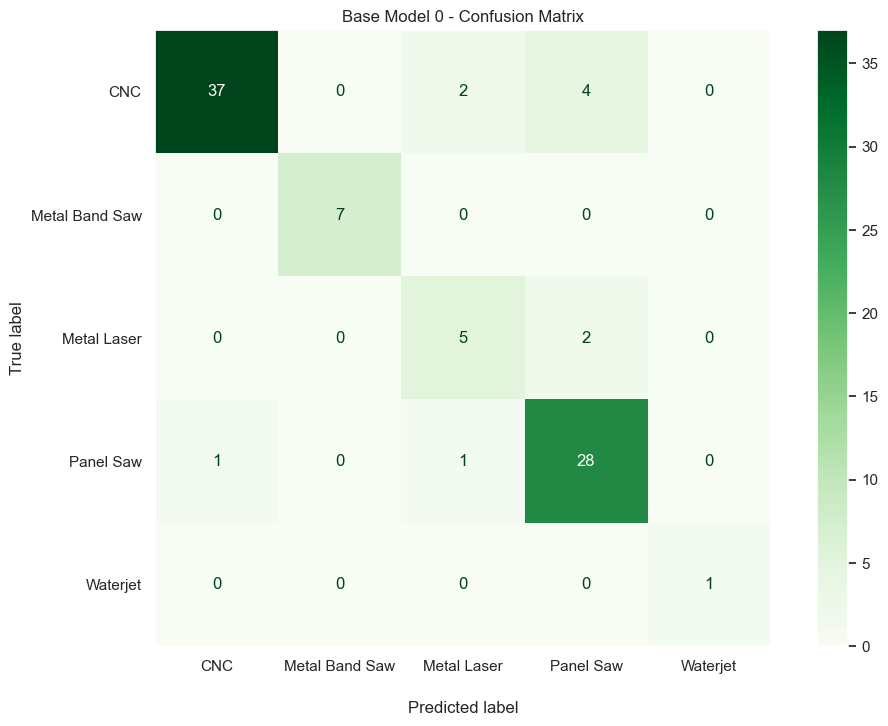

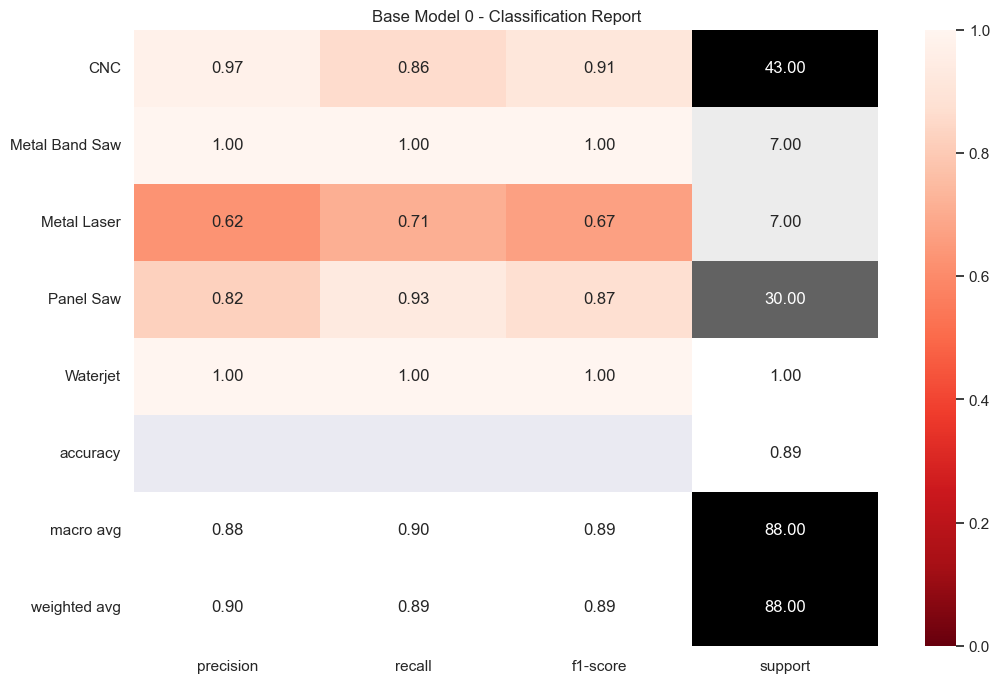

In [57]:
# create classification report and confuision matrix for first base model
show_classification_report_and_confusion_matrix(pointnet, 
                                                all_preds, 
                                                all_labels, 
                                                classes,
                                                'Greens', 
                                                'Reds_r', 
                                                'Base Model 0 - Confusion Matrix', 
                                                'Base Model 0 - Classification Report')

In [58]:
# Define a function to show the graph of train loss vs validation loss and the graph of train accuracy vs validation accuracy
def visualize_training_results(history):
    plt.figure()
    plt.plot(history['Val_Loss'])
    plt.plot(history['Loss'])
    plt.legend(['Val_Loss', 'Loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['Val_Accuracy'])
    plt.plot(history['Accuracy'])
    plt.legend(['Val_Accuracy', 'Accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Categorical Accuracy')
    plt.show()

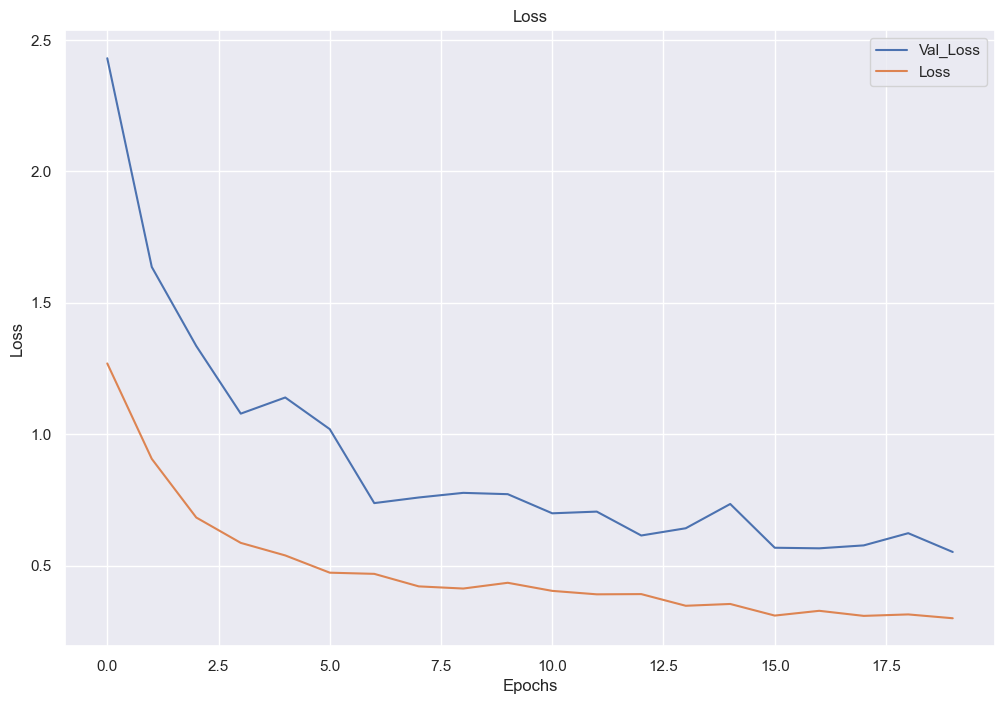

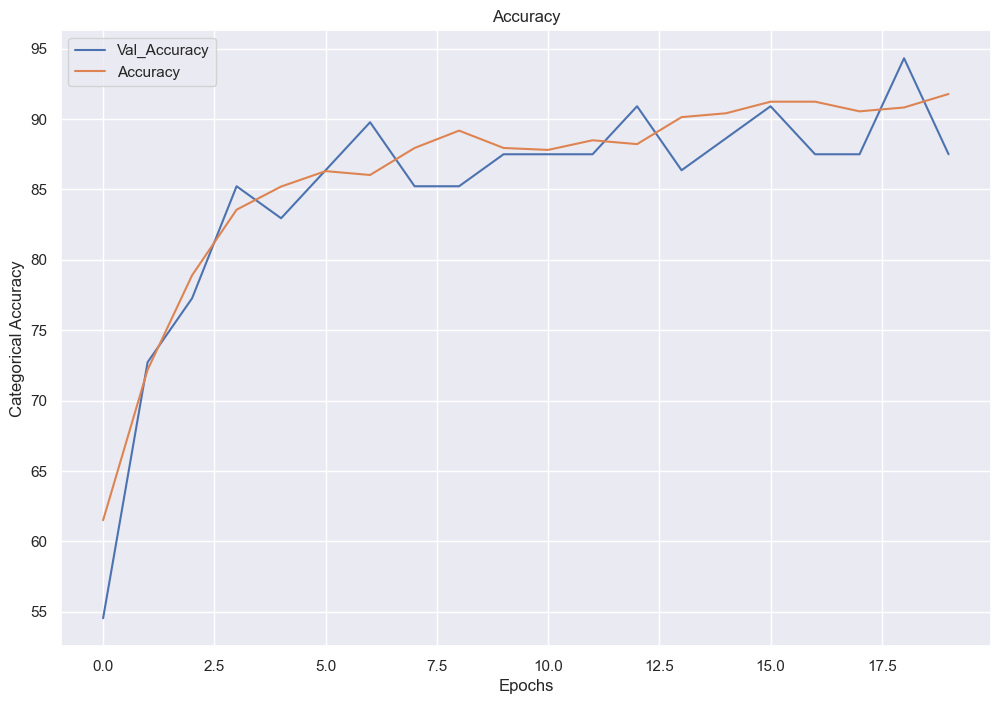

In [59]:
visualize_training_results(accuracy_loss_df)

We did not do so well on this one. Understandably so, considering that the model has not been adjusted at all.

## Model 1

For the next model, we will take the train dataset, augment some of the data, and feed it back into the same model. We will also manage the class imbalance by applying our class weights to the loss function within our model

In [60]:
class RandRotation_z(object):
    def __call__(self, mesh_verts):
        assert len(mesh_verts.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_mesh_verts = rot_matrix.dot(mesh_verts.T).T
        return  rot_mesh_verts
    
class RandomNoise(object):
    def __call__(self, mesh_verts):
        assert len(mesh_verts.shape)==2

        noise = np.random.normal(0, 0.02, (mesh_verts.shape))
    
        noisy_mesh_verts = mesh_verts + noise
        return  noisy_mesh_verts

class Normalize(object):
    def __call__(self, mesh):
        mesh_norm = normalize(mesh)

        return  mesh_norm

In [61]:
def Model_transforms():
    return transforms.Compose([
                                Normalize(),
                                RandRotation_z(),
                                RandomNoise()
                              ])

In [62]:
train_ds2 = MeshData(train_path, transform=Model_transforms(), num_samples=num_samples)

In [63]:
train_loader2 = DataLoader(dataset=train_ds2, batch_size=batch_size, shuffle=True)

In [64]:
pointnet2 = PointNet()
pointnet.to(device);

# Load a pre-trained model if it exists
# pointnet.load_state_dict(torch.load('../input/pointnet-for-3d-object-classification-pytorch/save.pth'))

# set optimizer to the adam optimizer
optimizer2 = torch.optim.Adam(pointnet2.parameters(), lr=0.00025)

In [65]:
import random

In [66]:
# run the training model
accuracy_loss2 = []
train(pointnet2, train_loader2, valid_loader, epochs, accuracy_loss2)

C:\Users\Tim\anaconda3\envs\pytorch3d\lib\site-packages\pytorch3d\io\obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


[Epoch: 1, Batch:    5 /   23], loss: 0.999
[Epoch: 1, Batch:   10 /   23], loss: 0.819
[Epoch: 1, Batch:   15 /   23], loss: 0.693
[Epoch: 1, Batch:   20 /   23], loss: 0.631
Valid Accuracy: 35 % - Accuracy: 57 % - Valid Loss: 122542.550
[Epoch: 2, Batch:    5 /   23], loss: 0.678
[Epoch: 2, Batch:   10 /   23], loss: 0.522
[Epoch: 2, Batch:   15 /   23], loss: 0.546
[Epoch: 2, Batch:   20 /   23], loss: 0.526
Valid Accuracy: 38 % - Accuracy: 61 % - Valid Loss: 18333937.188
[Epoch: 3, Batch:    5 /   23], loss: 0.558
[Epoch: 3, Batch:   10 /   23], loss: 0.455
[Epoch: 3, Batch:   15 /   23], loss: 0.564
[Epoch: 3, Batch:   20 /   23], loss: 0.535
Valid Accuracy: 31 % - Accuracy: 60 % - Valid Loss: 14860026.062
[Epoch: 4, Batch:    5 /   23], loss: 0.516
[Epoch: 4, Batch:   10 /   23], loss: 0.500
[Epoch: 4, Batch:   15 /   23], loss: 0.550
[Epoch: 4, Batch:   20 /   23], loss: 0.512
Valid Accuracy: 29 % - Accuracy: 63 % - Valid Loss: 12930118.188
[Epoch: 5, Batch:    5 /   23], loss: 

In [67]:
accuracy_loss_df2 = pd.DataFrame.from_records(accuracy_loss2)
accuracy_loss_df2 = accuracy_loss_df2.set_index('Epoch')
accuracy_loss_df2

,Loss,Accuracy,Val_Accuracy,Val_Loss
Epoch,,,,
0,1.513429,57.808219,35.227273,1.225426e+05
1,1.120415,61.232877,38.636364,1.833394e+07
2,1.046260,60.684932,31.818182,1.486003e+07
3,1.040009,63.013699,29.545455,1.293012e+07
4,1.000644,63.013699,28.409091,1.154563e+07
5,0.984025,62.054795,25.000000,2.220245e+07
6,1.012978,61.643836,30.681818,1.835864e+07
7,0.954113,65.205479,26.136364,1.428647e+07
8,0.963333,63.287671,32.954545,1.345359e+07


In [68]:
# evaluate the model to get predictions and true labels
pointnet2.eval()
all_preds2 = []
all_labels2 = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
        
        inputs, labels = data['mesh'].float(), data['category']
        outputs, __, __ = pointnet2(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds2 += list(preds.numpy())
        all_labels2 += list(labels.numpy())

C:\Users\Tim\anaconda3\envs\pytorch3d\lib\site-packages\pytorch3d\io\obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


Batch [   1 /    2]
Batch [   2 /    2]


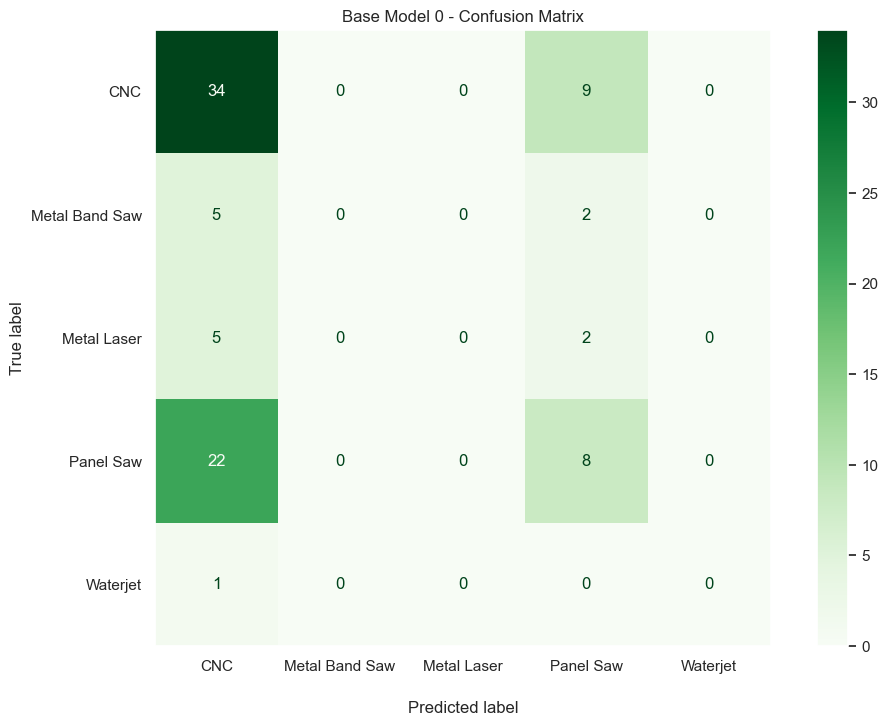

C:\Users\Tim\anaconda3\envs\pytorch3d\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tim\anaconda3\envs\pytorch3d\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tim\anaconda3\envs\pytorch3d\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


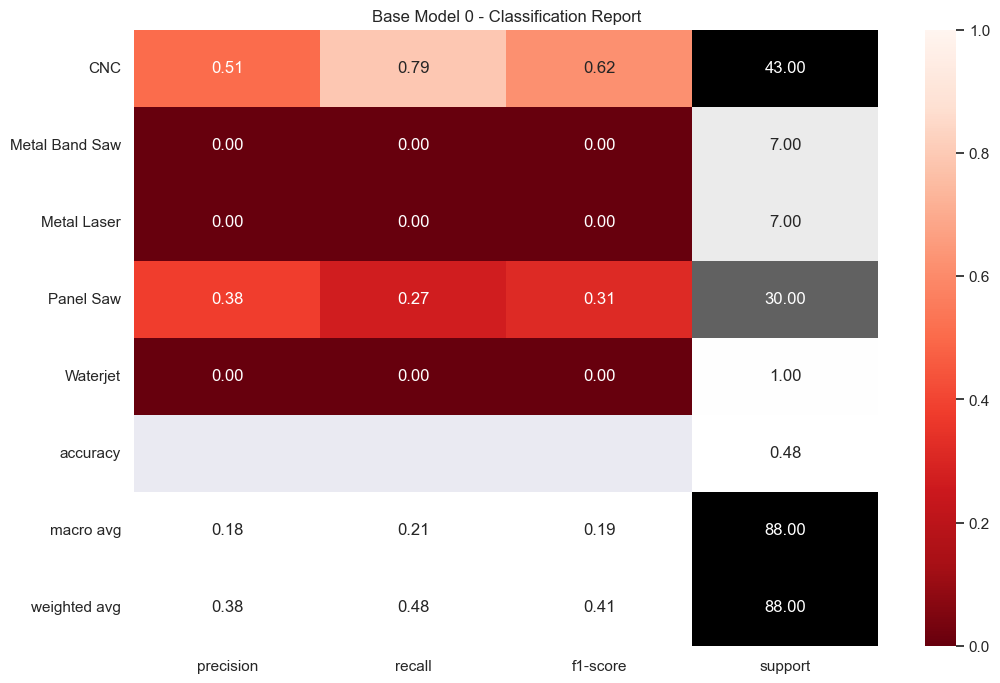

In [69]:
# create classification report and confuision matrix for first base model
show_classification_report_and_confusion_matrix(pointnet2, 
                                                all_preds2, 
                                                all_labels2, 
                                                classes,
                                                'Greens', 
                                                'Reds_r', 
                                                'Base Model 0 - Confusion Matrix', 
                                                'Base Model 0 - Classification Report')

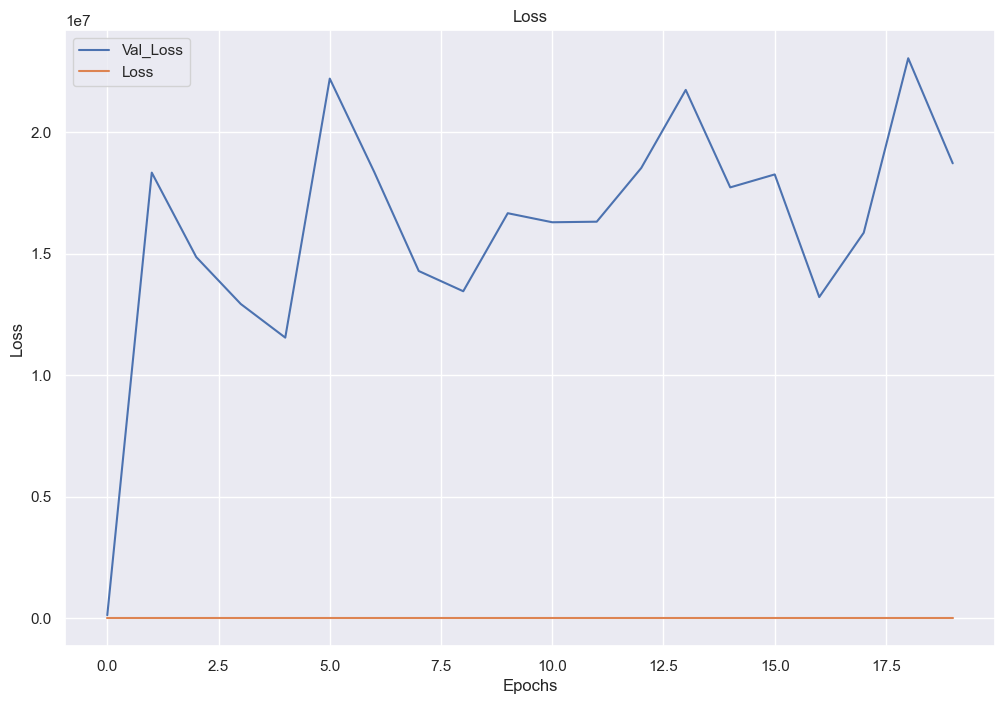

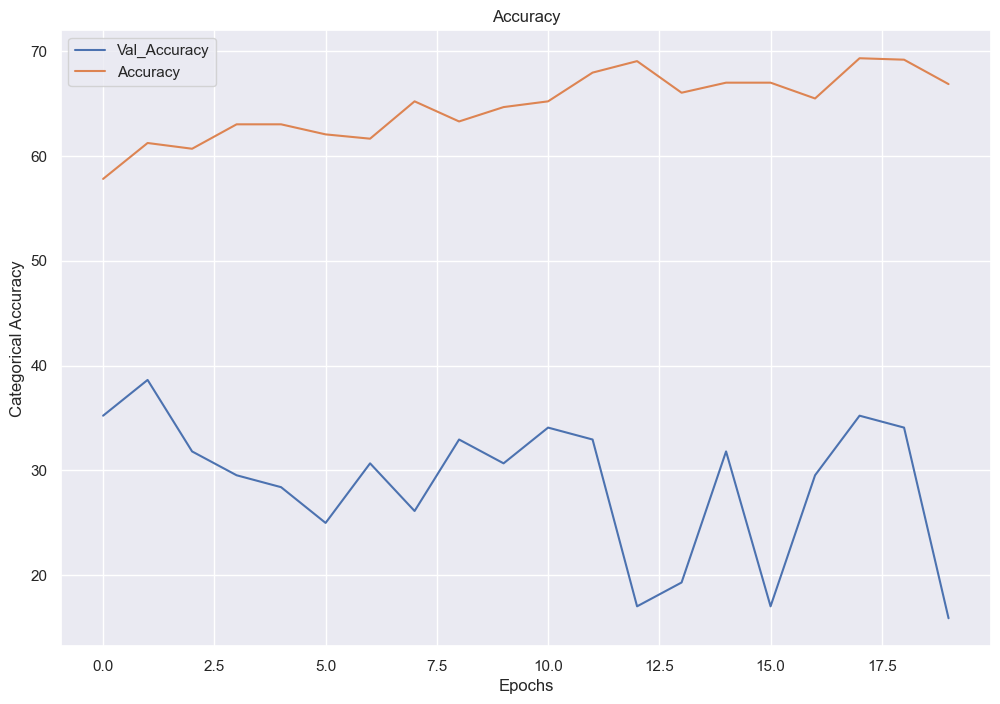

In [70]:
visualize_training_results(accuracy_loss_df2)

## Model 2

We add a convolution layer to each class and increased the amount of maximum channels to 4096. Add a additional dropout layer to prevent overfitting. In our last model, we also had a initial problem with loss, so changing our optimizer to AdamW should start to keep that under control

In [71]:
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.conv4 = nn.Conv1d(1024,4096,1)
        self.fc1 = nn.Linear(4096,1024)
        self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(4096)
        self.bn5 = nn.BatchNorm1d(2048)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        xb = F.relu(self.bn4(self.conv4(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn5(self.fc1(flat)))
        xb = F.relu(self.bn6(self.fc2(xb)))
        xb = F.relu(self.bn7(self.fc3(xb)))


        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc4(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.conv4 = nn.Conv1d(1024,4096,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(4096)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        xb = self.bn4(self.conv4(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet2(nn.Module):
    def __init__(self, classes = 5):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, classes)
        
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout1(self.fc2(xb))))
        xb = F.relu(self.bn3(self.dropout2(self.fc3(xb))))
        output = self.fc4(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [72]:
# set the device. If cuda is available, use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pointnet3 = PointNet2()
pointnet3.to(device);

# Load a pre-trained model if it exists
# pointnet.load_state_dict(torch.load('../input/pointnet-for-3d-object-classification-pytorch/save.pth'))

# set optimizer to the adam optimizer
optimizer3 = torch.optim.AdamW(pointnet3.parameters(), lr=0.00025)

In [73]:
# Set number of epochs
epochs = 50

In [74]:
# run the training model
accuracy_loss3 = []
train(pointnet3, train_loader2, valid_loader, epochs, accuracy_loss3)

C:\Users\Tim\anaconda3\envs\pytorch3d\lib\site-packages\pytorch3d\io\obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


[Epoch: 1, Batch:    5 /   23], loss: 0.462
[Epoch: 1, Batch:   10 /   23], loss: 0.436
[Epoch: 1, Batch:   15 /   23], loss: 0.386
[Epoch: 1, Batch:   20 /   23], loss: 0.406
Valid Accuracy: 27 % - Accuracy: 67 % - Valid Loss: 18342650.125
[Epoch: 2, Batch:    5 /   23], loss: 0.473
[Epoch: 2, Batch:   10 /   23], loss: 0.437
[Epoch: 2, Batch:   15 /   23], loss: 0.461
[Epoch: 2, Batch:   20 /   23], loss: 0.419
Valid Accuracy: 19 % - Accuracy: 67 % - Valid Loss: 23019384.750
[Epoch: 3, Batch:    5 /   23], loss: 0.401
[Epoch: 3, Batch:   10 /   23], loss: 0.380
[Epoch: 3, Batch:   15 /   23], loss: 0.449
[Epoch: 3, Batch:   20 /   23], loss: 0.444
Valid Accuracy: 31 % - Accuracy: 70 % - Valid Loss: 18056369.000
[Epoch: 4, Batch:    5 /   23], loss: 0.436
[Epoch: 4, Batch:   10 /   23], loss: 0.396
[Epoch: 4, Batch:   15 /   23], loss: 0.446
[Epoch: 4, Batch:   20 /   23], loss: 0.427
Valid Accuracy: 19 % - Accuracy: 68 % - Valid Loss: 12306939.375
[Epoch: 5, Batch:    5 /   23], loss

In [75]:
accuracy_loss_df3 = pd.DataFrame.from_records(accuracy_loss3)
accuracy_loss_df3 = accuracy_loss_df3.set_index('Epoch')
accuracy_loss_df3

,Loss,Accuracy,Val_Accuracy,Val_Loss
Epoch,,,,
0,0.861404,67.123288,27.272727,1.834265e+07
1,0.901904,67.808219,19.318182,2.301938e+07
2,0.847850,70.000000,31.818182,1.805637e+07
3,0.843804,68.082192,19.318182,1.230694e+07
4,0.832042,70.684932,28.409091,1.946584e+07
5,0.827174,70.410959,28.409091,2.221895e+07
6,0.836734,70.958904,14.772727,2.440928e+07
7,0.802720,71.232877,26.136364,1.690880e+07
8,0.827366,70.547945,14.772727,3.001505e+07


In [76]:
# evaluate the model to get predictions and true labels
pointnet.eval()
all_preds3 = []
all_labels3 = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
        
        inputs, labels = data['mesh'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds3 += list(preds.numpy())
        all_labels3 += list(labels.numpy())

C:\Users\Tim\anaconda3\envs\pytorch3d\lib\site-packages\pytorch3d\io\obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


Batch [   1 /    2]
Batch [   2 /    2]


# Evaluation (Final Model Interpretation)

## Plot Correct and Incorrect Predictions

In [77]:
all_preds_fin = []
all_labels_fin = []
class_pred_array = []
mesh_test_array = []

for i, data in enumerate(valid_loader, 0):
            inputs, labels = data['mesh'].to(device).float(), data['category']
            outputs, _, _ = pointnet(inputs.transpose(1,2))
            _, preds = torch.max(outputs.data, 1)
            all_preds_fin += list(preds.numpy())
            all_labels_fin += list(labels.numpy())
            class_pred_array.append(outputs)
            mesh_test_array.append(inputs)

In [78]:
class_pred_array = torch.cat(class_pred_array)
mesh_test_array = torch.cat(mesh_test_array)

In [79]:
# Identify indexs of correct and incorrect identified meshes
correct = np.nonzero(np.asarray(all_labels_fin) == np.asarray(all_preds_fin))
incorrect = np.nonzero(np.asarray(all_labels_fin) != np.asarray(all_preds_fin))

C:\Users\Tim\AppData\Local\Temp\ipykernel_18300\2262950757.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3,3,i+1, projection='3d')


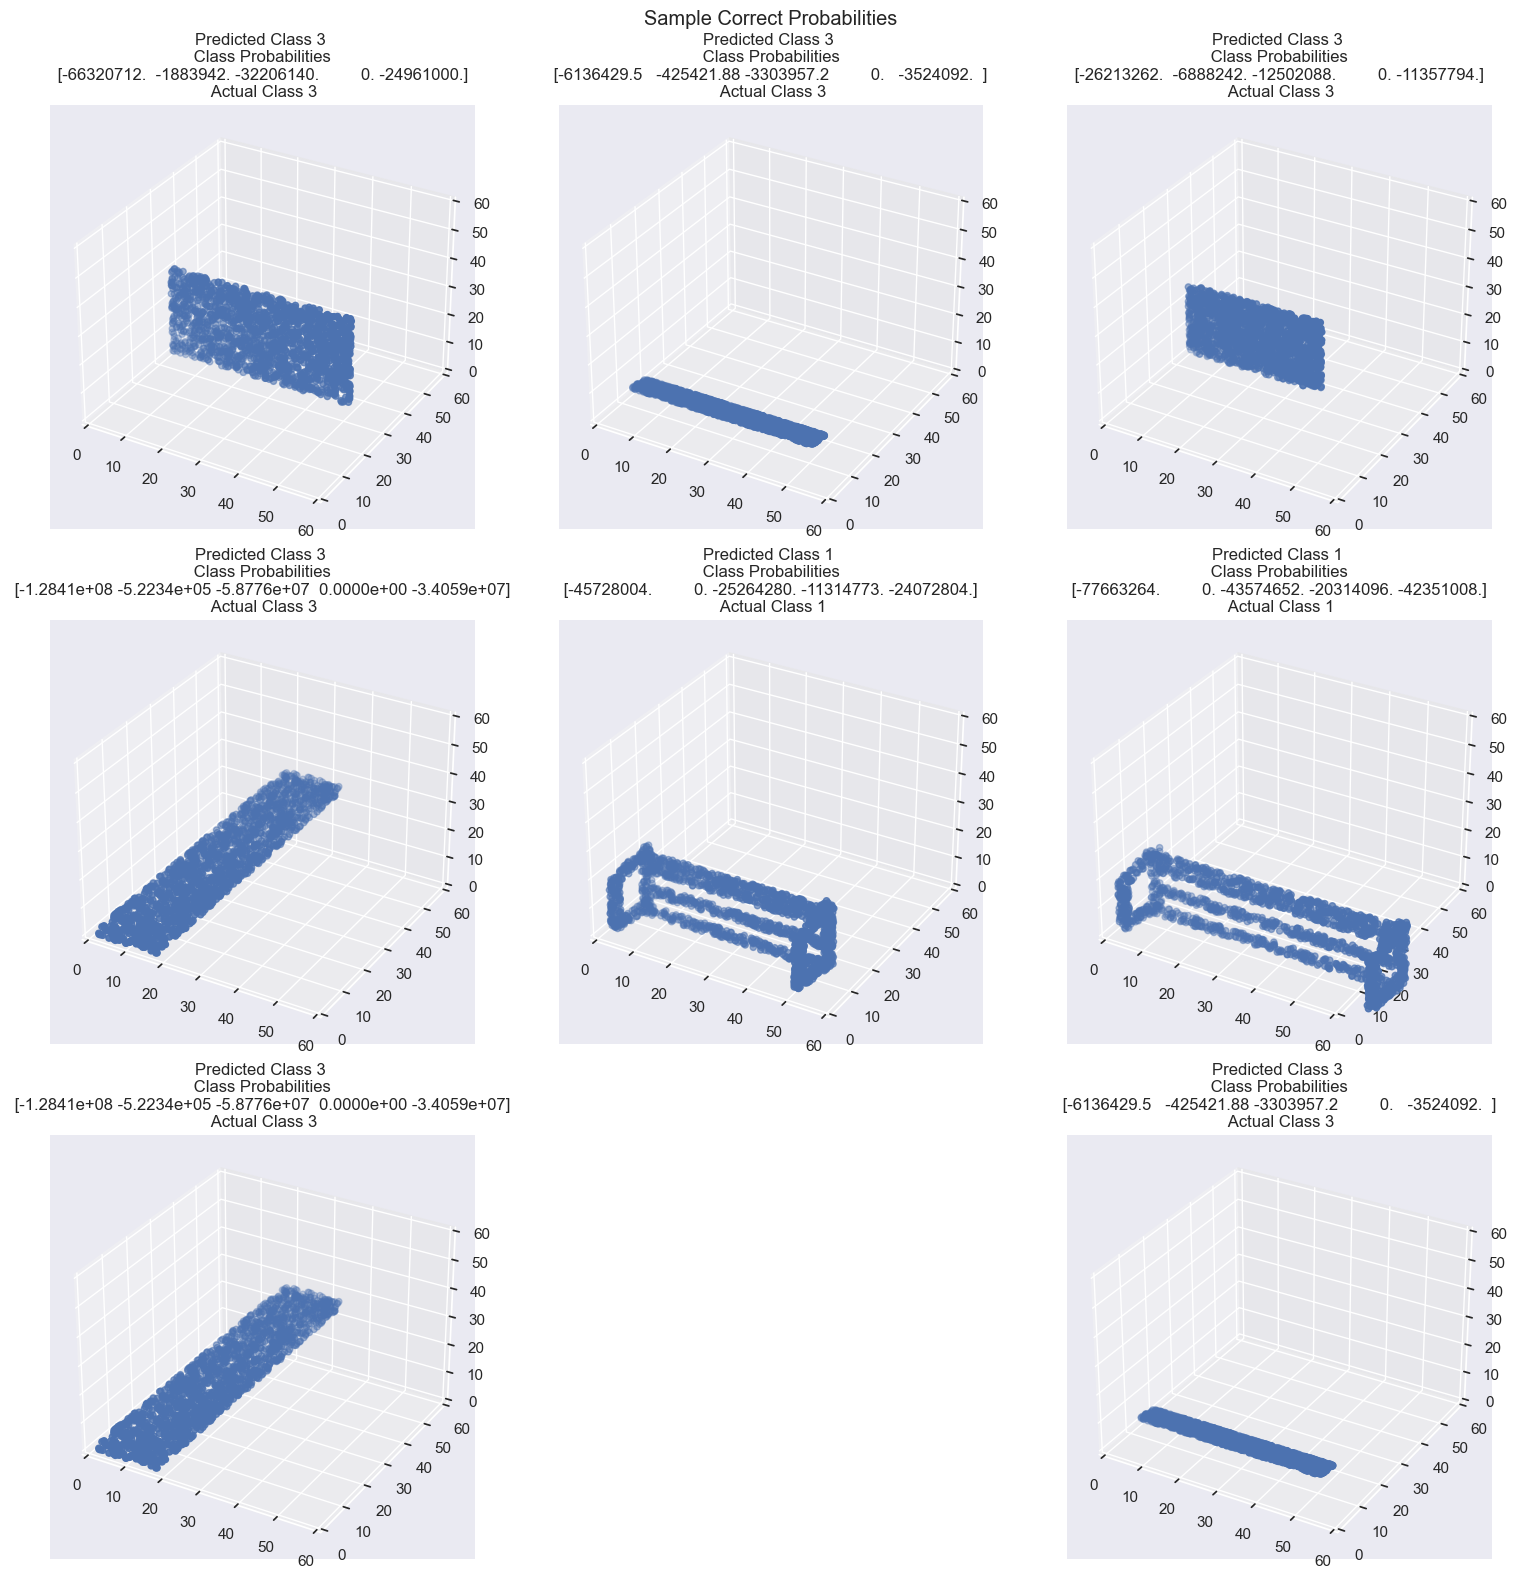

In [80]:
# Use a for loop to iterate through correct predictions,
# display the prediction values for each image and the actual class of the model
np.set_printoptions(precision=4)
correct_sample = np.random.choice(correct[0], size = 9)
i = 0
fig = plt.figure(figsize=(16,16))
fig.suptitle('Sample Correct Probabilities')
for c in correct_sample:
    ax = plt.subplot(3,3,i+1, projection='3d')
    mesh = mesh_test_array[c]
    ax.scatter(mesh[:,0], mesh[:,1], mesh[:,2])
    ax.set_xlim3d(0, 60)
    ax.set_ylim3d(0, 60)
    ax.set_zlim3d(0, 60)
    plt.title(
        'Predicted Class {} \n Class Probabilities \n {} \n Actual Class {}'.format(
            all_preds_fin[c], 
            class_pred_array[c].detach().numpy(), 
            all_labels_fin[c]))
    plt.tight_layout()
    i += 1


plt.show();

C:\Users\Tim\AppData\Local\Temp\ipykernel_18300\3825481104.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(3,3,i+1, projection='3d')


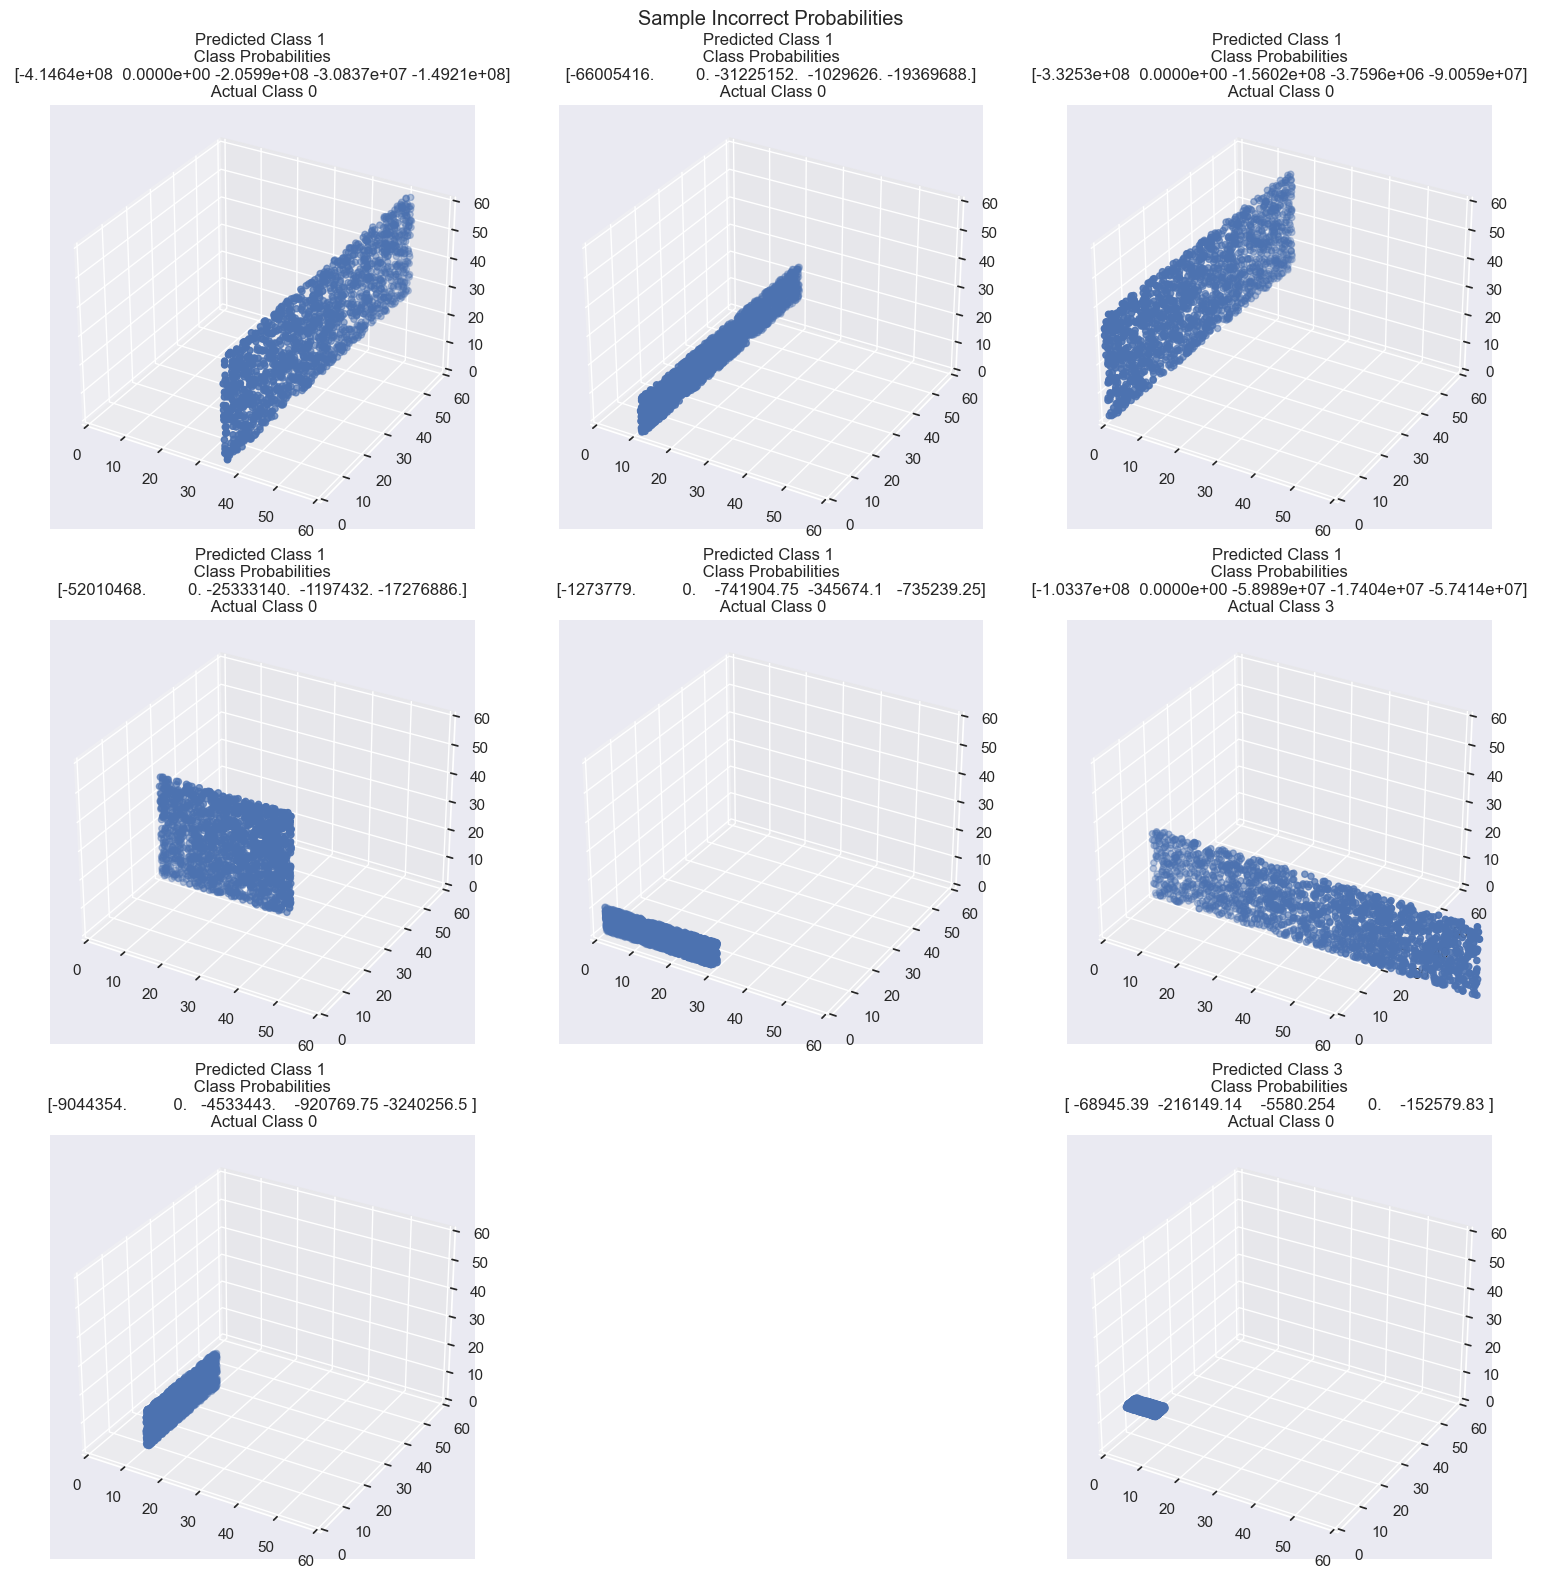

In [81]:
# Use a for loop to iterate through incorrect predictions,
# display the prediction values for each image and the actual class of the model
np.set_printoptions(precision=4)
incorrect_sample = np.random.choice(incorrect[0], size = 9)
i = 0
fig = plt.figure(figsize=(16,16))
fig.suptitle('Sample Incorrect Probabilities')
for c in incorrect_sample:
    ax = plt.subplot(3,3,i+1, projection='3d')
    mesh = mesh_test_array[c]
    ax.scatter(mesh[:,0], mesh[:,1], mesh[:,2])
    ax.set_xlim3d(0, 60)
    ax.set_ylim3d(0, 60)
    ax.set_zlim3d(0, 60)
    plt.title(
        'Predicted Class {} \n Class Probabilities \n {} \n Actual Class {}'.format(
            all_preds_fin[c], 
            class_pred_array[c].detach().numpy(), 
            all_labels_fin[c]))
    plt.tight_layout()
    i += 1


plt.show();

# Recommendations

- In the cost material analysis, we would want to calculate the square footage of each individual part and then use that as a basis to determine more accurate costs based on the current dataset

- In the time cost analysis, we would want to hook up an analysis program to each machine that would store the program and run time for each program, in order to have a more accurate average of time estimates per machine. Those time estimates would then be fed into a program which could estimate program run times for the part models that we have in the dataset.

## Model Implementation

The final model above is a step towards making this a reality for an entire ecosystem of automation.

- Increase the amount of data that the algorithm trains on. While 1,000 meshes is a good start, 10,000 or 20, 000 would be even better for improving the performance of the model.

- Integrate the materials into the modeling to improve model performance.

- The modeling was done mainly off of the PointNet pointcloud nueral network architecture. The data would benefit from having another model or two that had a different architecture, just to be able to compare the differneces between them.

- Integrating the face normals of the meshes would contribute to improving performance for the model as it would be able to analyze the face information along with the point information.